In [2]:
!pip install numpy==1.23.5

In [3]:
pip install pyclustering

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, normaltest, shapiro
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import MeanShift, estimate_bandwidth
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import calculate_distance_matrix
from itertools import product
import warnings
import matplotlib.patches as mpatches

In [5]:
file_path = 'C:/Users/57319/Downloads/CAOBA/original.csv'  # Adjust this path as needed
df = pd.read_csv(file_path)

In [6]:
df.describe

<bound method NDFrame.describe of           CodigoEstacion  CodigoSensor        FechaObservacion  \
0               24035360            70  05/22/2011 03:59:00 AM   
1               21206790            70  10/03/2015 02:01:00 AM   
2               21215150            70  06/01/2018 09:16:00 PM   
3               21015040            70  02/10/2017 07:23:00 PM   
4               24035380            70  01/29/2015 05:00:00 PM   
...                  ...           ...                     ...   
21037432        15065501            70  01/15/2023 05:00:00 AM   
21037433        11080010            70  01/15/2023 05:30:00 PM   
21037434        26225060            70  01/15/2023 11:09:00 AM   
21037435        26015010            70  01/15/2023 01:26:00 AM   
21037436        26015030            70  01/15/2023 08:08:00 PM   

          ValorObservado            NombreEstacion  Departamento  \
0                   12.5               SOCHA - AUT        BOYACÁ   
1                   11.8  HACIENDA SA

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21037437 entries, 0 to 21037436
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   CodigoEstacion     int64  
 1   CodigoSensor       int64  
 2   FechaObservacion   object 
 3   ValorObservado     float64
 4   NombreEstacion     object 
 5   Departamento       object 
 6   Municipio          object 
 7   ZonaHidrografica   object 
 8   Latitud            float64
 9   Longitud           float64
 10  DescripcionSensor  object 
 11  UnidadMedida       object 
dtypes: float64(3), int64(2), object(7)
memory usage: 1.9+ GB


In [8]:
df.head()

CodigoEstacion  CodigoSensor        FechaObservacion  ValorObservado  \
0        24035360            70  05/22/2011 03:59:00 AM            12.5   
1        21206790            70  10/03/2015 02:01:00 AM            11.8   
2        21215150            70  06/01/2018 09:16:00 PM             1.2   
3        21015040            70  02/10/2017 07:23:00 PM            16.0   
4        24035380            70  01/29/2015 05:00:00 PM             3.0   

             NombreEstacion  Departamento     Municipio ZonaHidrografica  \
0               SOCHA - AUT        BOYACÁ         SOCHA         SOGAMOSO   
1  HACIENDA SANTA ANA - AUT  CUNDINAMARCA       NEMOCÓN   ALTO MAGDALENA   
2  NEVADO DEL TOLIMA  - AUT        TOLIMA    ANZOÁTEGUI   ALTO MAGDALENA   
3        LA PRIMAVERA - AUT         HUILA  SALADOBLANCO   ALTO MAGDALENA   
4    NEVADO DEL COCUY - AUT        BOYACÁ        GUICÁN         SOGAMOSO   

    Latitud   Longitud  DescripcionSensor UnidadMedida  
0  5.985417 -72.997028  Temp Min Aire 2 m           °C  
1  5.090500 -73.881250  Temp Min Aire 2 m           °C  
2  4.670778 -75.327778  Temp Min Aire 2 m           °C  
3  2.021583 -76.114333  Temp Min Aire 2 m           °C  
4  6.509111 -72.314167  Temp Min Aire 2 m           °C

In [9]:
# Lista de columnas a eliminar
columnas_a_eliminar = [
    "CodigoEstacion", 
    "CodigoSensor", 
    "NombreEstacion", 
    "Departamento", 
    "ZonaHidrografica", 
    "DescripcionSensor", 
    "UnidadMedida",
    "Latitud",
    "Longitud"
]

# Eliminar las columnas del DataFrame
new_df1 = df.drop(columns=columnas_a_eliminar)

# Mostrar el DataFrame actualizado
print(new_df1)


                FechaObservacion  ValorObservado              Municipio
0         05/22/2011 03:59:00 AM            12.5                  SOCHA
1         10/03/2015 02:01:00 AM            11.8                NEMOCÓN
2         06/01/2018 09:16:00 PM             1.2             ANZOÁTEGUI
3         02/10/2017 07:23:00 PM            16.0           SALADOBLANCO
4         01/29/2015 05:00:00 PM             3.0                 GUICÁN
...                          ...             ...                    ...
21037432  01/15/2023 05:00:00 AM            24.1                ALBANIA
21037433  01/15/2023 05:30:00 PM            26.1    BOJAYÁ (BELLAVISTA)
21037434  01/15/2023 11:09:00 AM            30.7  SANTA FE DE ANTIOQUIA
21037435  01/15/2023 01:26:00 AM            14.2                POPAYÁN
21037436  01/15/2023 08:08:00 PM             6.5      PURACÉ (COCONUCO)

[21037437 rows x 3 columns]


In [10]:
# Define the list of municipios to keep
keep_municipios = [
    "LETICIA", "MEDELLÍN", "ARAUCA", "BARRANQUILLA", "CARTAGENA", "QUÍPAMA",
    "MANIZALES", "FLORENCIA", "YOPAL", "POPAYÁN", "VALLEDUPAR", "QUIBDÓ",
    "MONTERÍA", "CHÍA", "INÍRIDA", "SAN JOSÉ DEL GUAVIARE", "NEIVA",
    "RIOHACHA", "SANTA MARTA", "VILLAVICENCIO", "PASTO", "CÚCUTA", "MOCOA",
    "ARMENIA", "PEREIRA", "SAN ANDRÉS", "BUCARAMANGA", "SINCELEJO", "IBAGUÉ",
    "CALI", "MITÚ", "LA PRIMAVERA"
]

# Filter rows where 'Municipio' is in the keep list
new_df2 = new_df1[new_df1['Municipio'].isin(keep_municipios)]

In [11]:
new_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4412086 entries, 7 to 21037435
Data columns (total 3 columns):
 #   Column            Dtype  
---  ------            -----  
 0   FechaObservacion  object 
 1   ValorObservado    float64
 2   Municipio         object 
dtypes: float64(1), object(2)
memory usage: 134.6+ MB


In [12]:
# Define the city column
city_column = 'Municipio' if 'Municipio' in new_df2.columns else 'Municipio' if 'Municipio' in new_df2.columns else None

# Rename specific city values
if city_column:
    # Define the renaming dictionary
    city_renaming = {
        "QUÍPAMA": "TUNJA",
        "CHÍA": "BOGOTÁ",
        "LA PRIMAVERA": "PUERTO CARREÑO"
    }
    
    # Perform the renaming
    new_df2[city_column] = new_df2[city_column].replace(city_renaming)
    print("City names updated successfully.")
    
    # Verify changes
    print(new_df2[city_column].unique())
else:
    print("City column not found. Ensure the dataset has a 'City' or 'Municipio' column.")


City names updated successfully.
['PASTO' 'MOCOA' 'MANIZALES' 'CALI' 'CARTAGENA' 'FLORENCIA' 'MEDELLÍN'
 'BUCARAMANGA' 'BARRANQUILLA' 'CÚCUTA' 'SAN ANDRÉS' 'PEREIRA' 'RIOHACHA'
 'POPAYÁN' 'VALLEDUPAR' 'IBAGUÉ' 'MONTERÍA' 'SINCELEJO' 'QUIBDÓ' 'INÍRIDA'
 'NEIVA' 'LETICIA' 'SANTA MARTA' 'ARMENIA' 'VILLAVICENCIO' 'YOPAL'
 'SAN JOSÉ DEL GUAVIARE' 'ARAUCA' 'TUNJA' 'BOGOTÁ' 'PUERTO CARREÑO']


C:\Users\57319\AppData\Local\Temp\ipykernel_24076\2179103972.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df2[city_column] = new_df2[city_column].replace(city_renaming)


In [13]:

# Rename the column "Municipio" to "Ciudad"
if "Municipio" in new_df2.columns:
    new_df2.rename(columns={"Municipio": "Ciudad"}, inplace=True)
    print("Column 'Municipio' successfully renamed to 'Ciudad'.")
    print(new_df2.head())  # Display the updated dataset's first few rows
else:
    print("The column 'Municipio' does not exist in the dataset.")


Column 'Municipio' successfully renamed to 'Ciudad'.
          FechaObservacion  ValorObservado     Ciudad
7   04/30/2011 04:58:00 AM            12.8      PASTO
16  09/22/2007 11:46:00 PM            21.1      MOCOA
20  03/21/2006 08:58:00 PM            15.8  MANIZALES
24  02/04/2014 11:00:00 AM            16.3      PASTO
28  08/29/2015 05:37:00 PM            18.1       CALI


C:\Users\57319\AppData\Local\Temp\ipykernel_24076\1848981012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df2.rename(columns={"Municipio": "Ciudad"}, inplace=True)


In [14]:
new_df2['Ciudad'].describe()

count     4412086
unique         31
top          CALI
freq       442466
Name: Ciudad, dtype: object

In [15]:
# Define the list of municipios to keep
Ciudades = [
    "MEDELLÍN", "BARRANQUILLA", "MANIZALES", "FLORENCIA", "YOPAL", "POPAYÁN", "VALLEDUPAR", "MONTERÍA", "INÍRIDA", "SAN JOSÉ DEL GUAVIARE", "NEIVA", "SANTA MARTA", "VILLAVICENCIO", "PASTO", "CÚCUTA", "MOCOA", "ARMENIA", "PEREIRA", "BUCARAMANGA", "IBAGUÉ", "CALI", 
]

# Filter rows where 'Municipio' is in the keep list
new_df3 = new_df2[new_df2['Ciudad'].isin(Ciudades)]

# Asegúrate de que la columna 'FechaObservacion' esté en el DataFrame correcto
new_df3['FechaObservacion'] = pd.to_datetime(new_df3['FechaObservacion'], errors='coerce')

# Elimina filas con valores no válidos (NaT) en 'FechaObservacion'
new_df_3 = new_df3.dropna(subset=['FechaObservacion'])

# Define la fecha límite
fecha_limite = pd.Timestamp('2012-01-01 00:01:00')

# Filtra el DataFrame para mantener solo las filas con fechas mayores o iguales al límite
new_df_filtrado = new_df_3[new_df_3['FechaObservacion'] >= fecha_limite]

# Muestra el DataFrame filtrado
print(new_df_filtrado)


            FechaObservacion  ValorObservado        Ciudad
24       2014-02-04 11:00:00            16.3         PASTO
28       2015-08-29 17:37:00            18.1          CALI
65       2019-03-21 16:59:00            24.7   BUCARAMANGA
75       2013-09-07 14:16:00            29.2  BARRANQUILLA
83       2017-02-12 18:58:00            24.3   BUCARAMANGA
...                      ...             ...           ...
21037381 2023-01-15 09:02:00            28.2    VALLEDUPAR
21037382 2023-01-15 09:08:00            13.0         PASTO
21037395 2023-01-15 04:43:00            24.2    VALLEDUPAR
21037407 2023-01-15 01:34:00            14.0     MANIZALES
21037435 2023-01-15 01:26:00            14.2       POPAYÁN

[2758412 rows x 3 columns]


C:\Users\57319\AppData\Local\Temp\ipykernel_24076\1250536072.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df3['FechaObservacion'] = pd.to_datetime(new_df3['FechaObservacion'], errors='coerce')


In [16]:
new_df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3883325 entries, 7 to 21037435
Data columns (total 3 columns):
 #   Column            Dtype         
---  ------            -----         
 0   FechaObservacion  datetime64[ns]
 1   ValorObservado    float64       
 2   Ciudad            object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 118.5+ MB


In [17]:
# Mostrar los valores únicos de la columna "Ciudad"
valores_unicos = new_df3["Ciudad"].unique()
print("Valores únicos en la columna 'Ciudad':")
print(valores_unicos)


Valores únicos en la columna 'Ciudad':
['PASTO' 'MOCOA' 'MANIZALES' 'CALI' 'FLORENCIA' 'MEDELLÍN' 'BUCARAMANGA'
 'BARRANQUILLA' 'CÚCUTA' 'PEREIRA' 'POPAYÁN' 'VALLEDUPAR' 'IBAGUÉ'
 'MONTERÍA' 'INÍRIDA' 'NEIVA' 'SANTA MARTA' 'ARMENIA' 'VILLAVICENCIO'
 'YOPAL' 'SAN JOSÉ DEL GUAVIARE']


In [18]:
# Guardar el nuevo dataset sin los outliers en formato CSV
new_df_filtrado.to_csv("datos_modelo.csv", index=False)

print("El dataset sin outliers ha sido guardado exitosamente en el formato especificado.")


El dataset sin outliers ha sido guardado exitosamente en el formato especificado.


**DATASET REDUCIDO**

In [19]:
# Reload the dataset
file_path = "C:/Users/57319/Downloads/datos_modelos.csv"  # Updated file path
df_modelo = pd.read_csv(file_path)

# Obtener la lista de ciudades únicas
ciudades = df_modelo['Ciudad'].unique()


In [20]:
df_modelo.head()

FechaObservacion  ValorObservado   Ciudad
0  2012-01-01 01:58:00.000000000       23.277243  ARMENIA
1  2012-01-01 02:17:47.500761118       18.500586  ARMENIA
2  2012-01-01 02:37:35.001522236       18.728605  ARMENIA
3  2012-01-01 02:57:22.502283354       22.302668  ARMENIA
4  2012-01-01 03:17:10.003044473       25.286728  ARMENIA

In [21]:
df_modelo.shape

(6139014, 3)

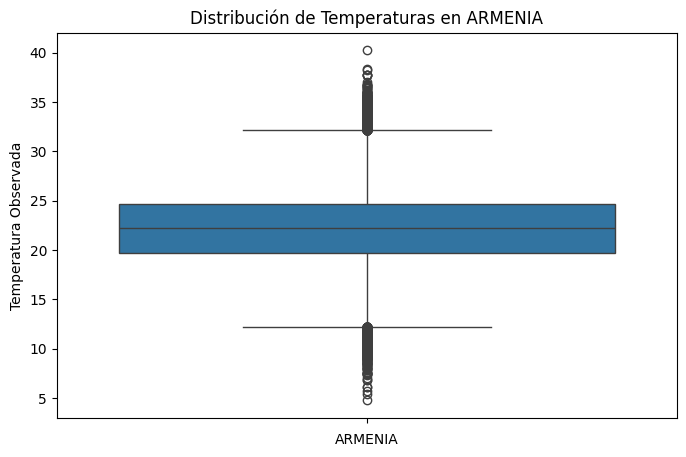

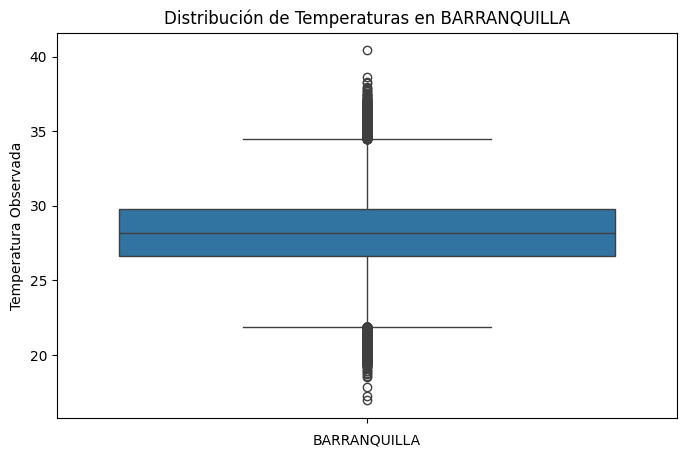

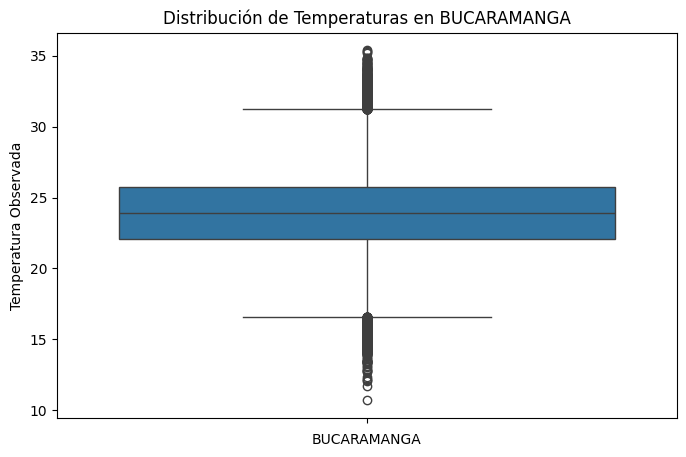

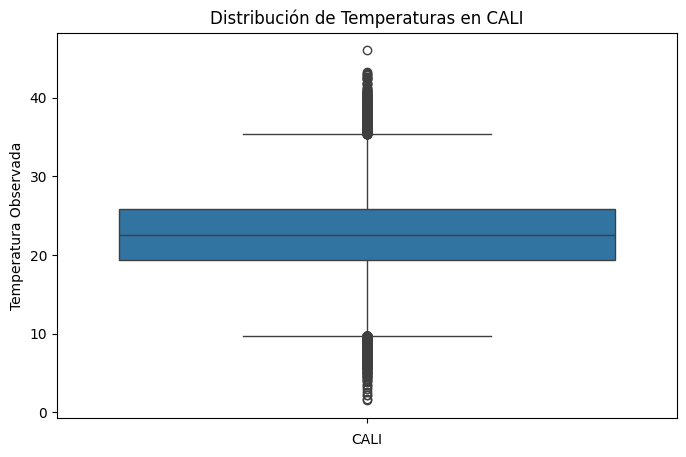

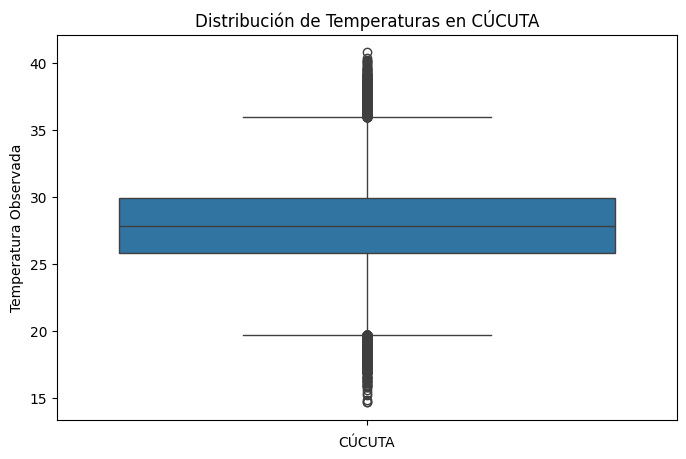

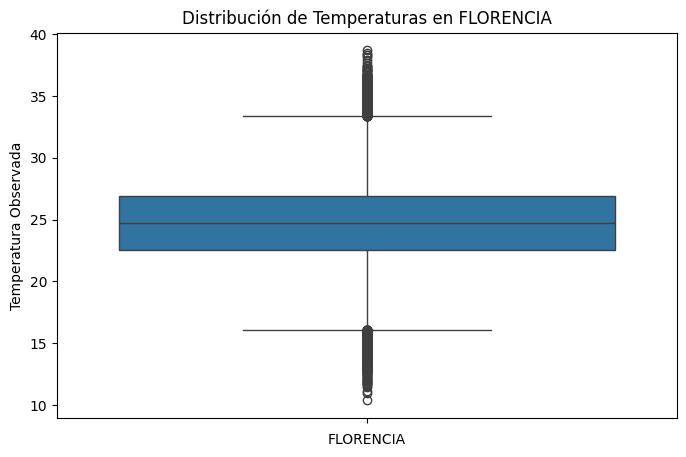

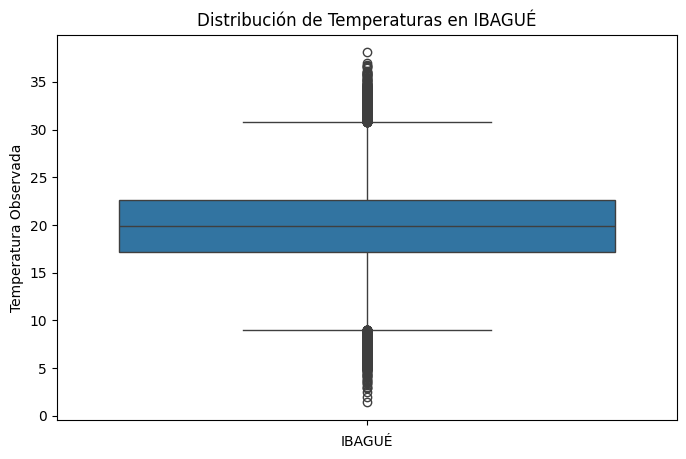

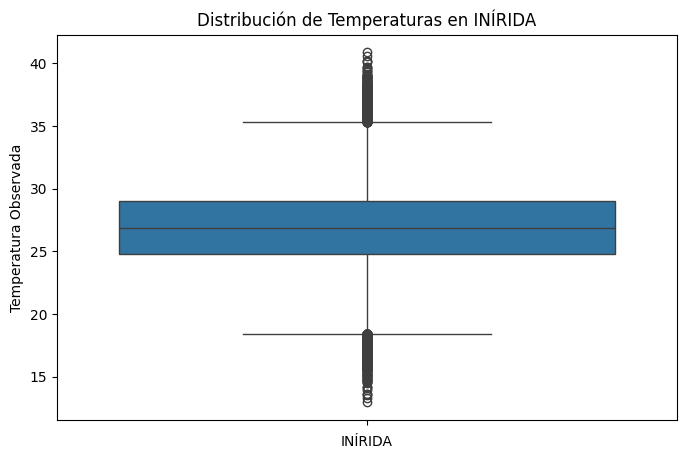

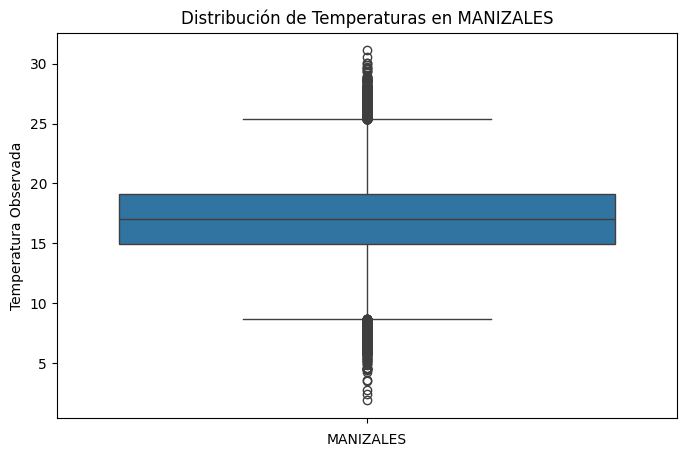

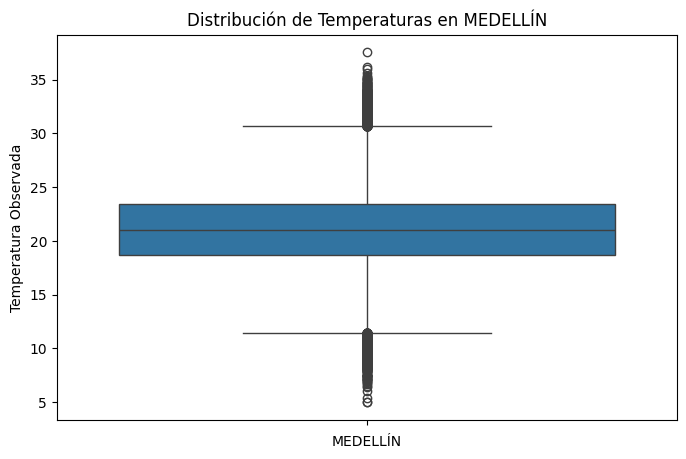

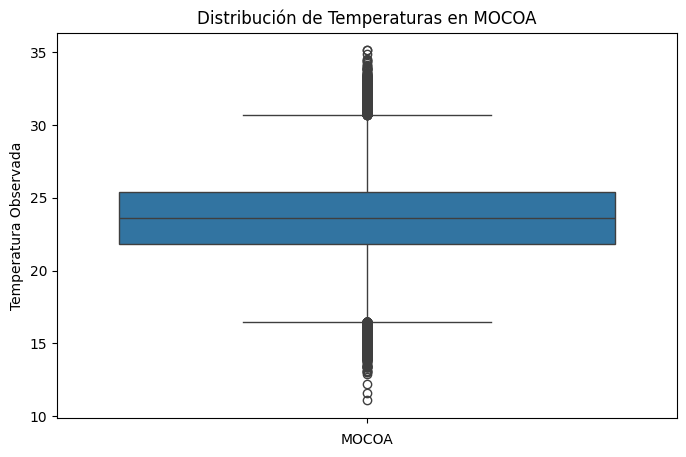

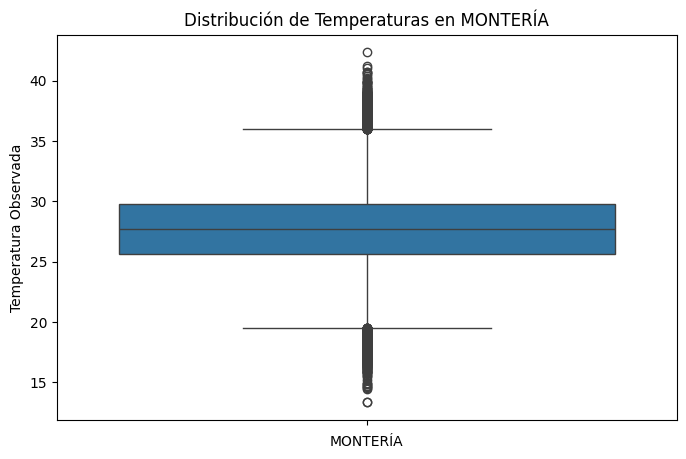

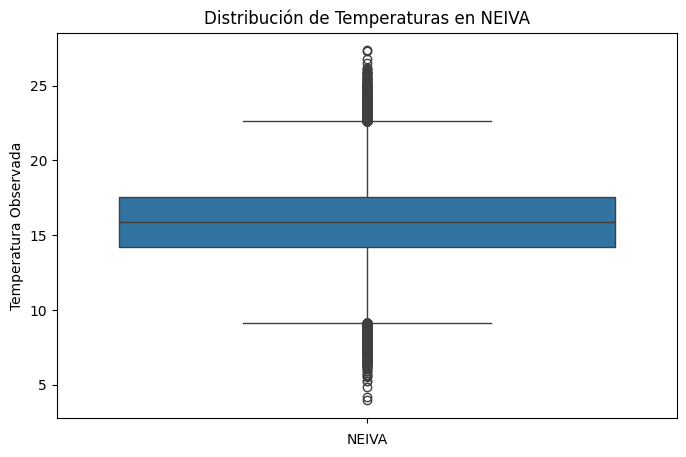

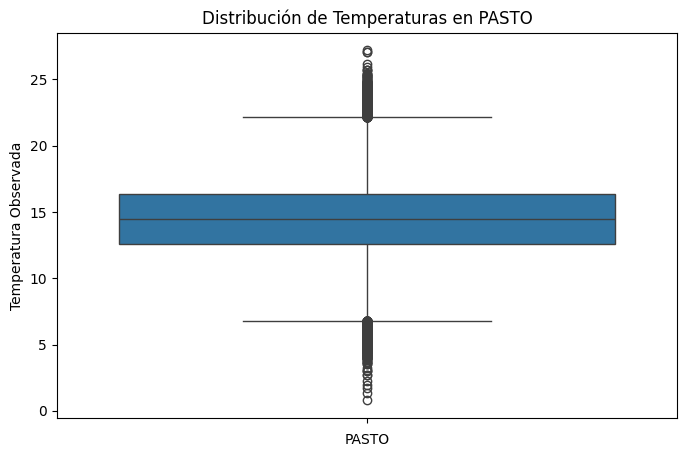

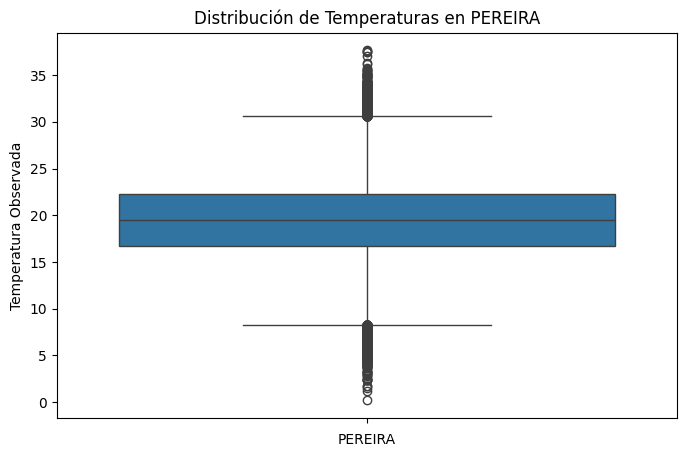

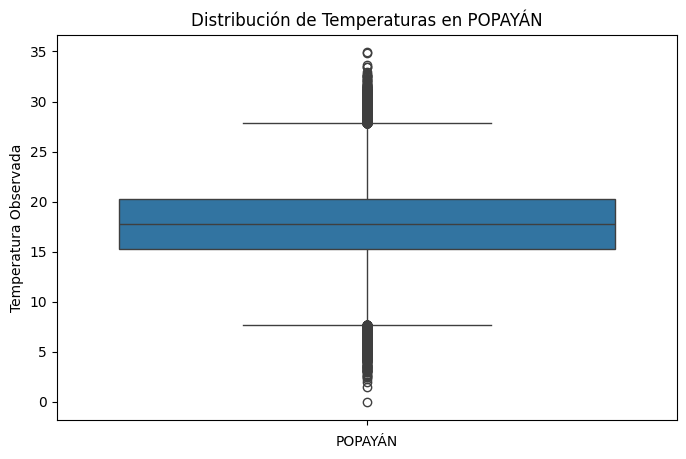

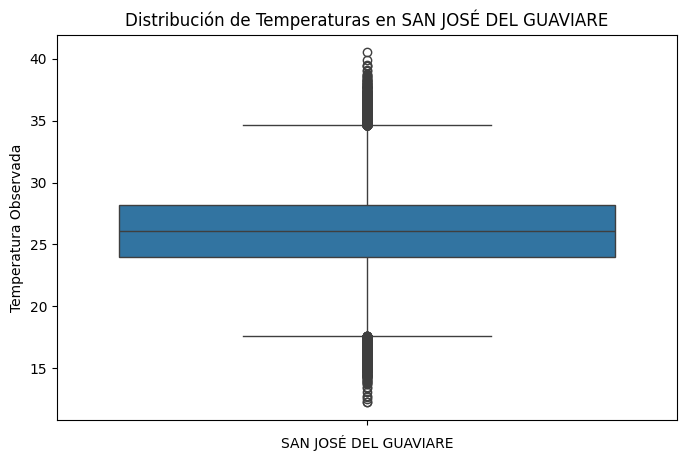

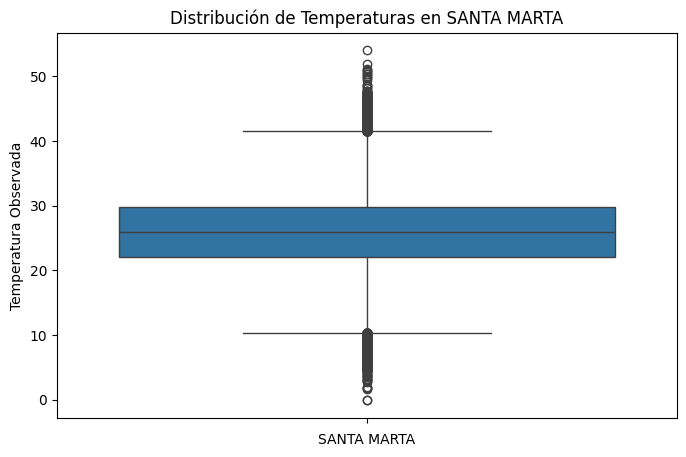

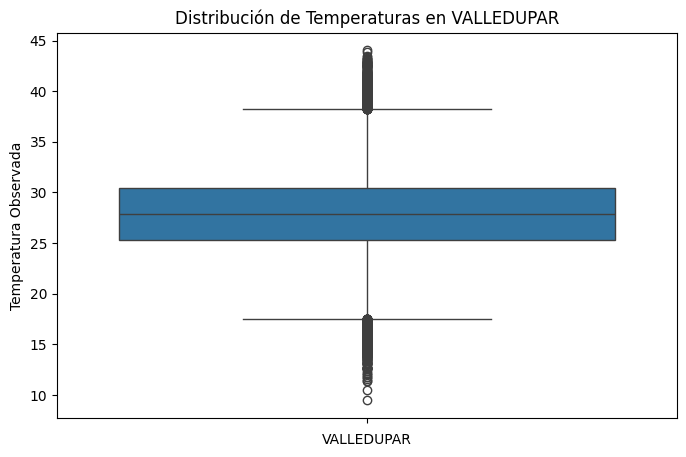

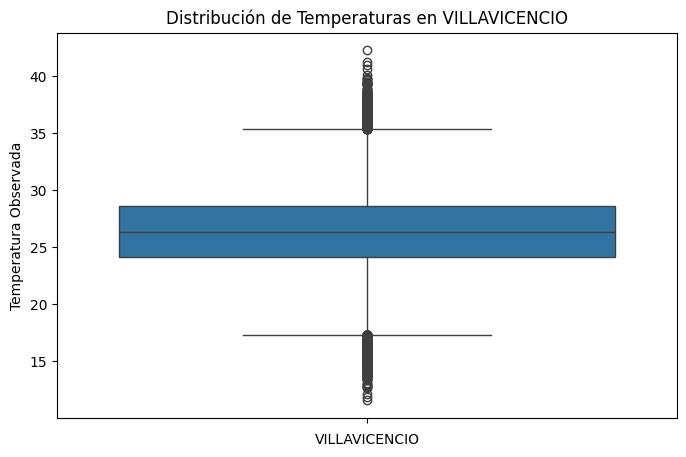

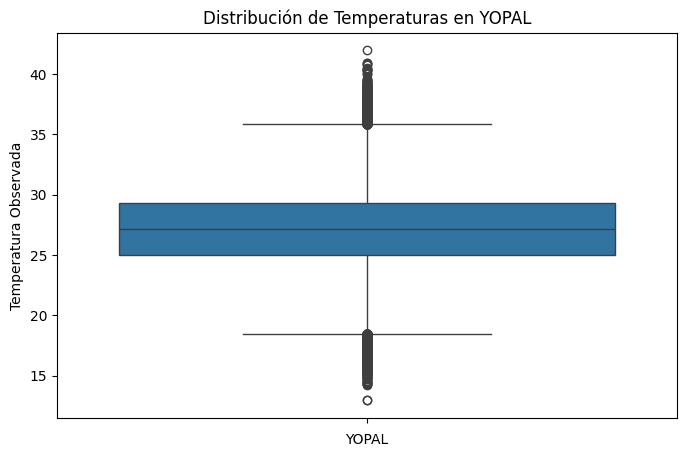

In [22]:

# Crear un boxplot para cada ciudad y mostrarlo en Python
for ciudad in ciudades:
    # Filtrar los datos por ciudad
    datos_ciudad = df_modelo[df_modelo['Ciudad'] == ciudad]

    # Configurar el tamaño del gráfico
    plt.figure(figsize=(8, 5))

    # Crear el boxplot para la ciudad actual
    sns.boxplot(data=datos_ciudad, y='ValorObservado')

    # Añadir título y etiquetas
    plt.title(f'Distribución de Temperaturas en {ciudad}')
    plt.ylabel('Temperatura Observada')
    plt.xlabel(ciudad)

    # Mostrar el gráfico
    plt.show()

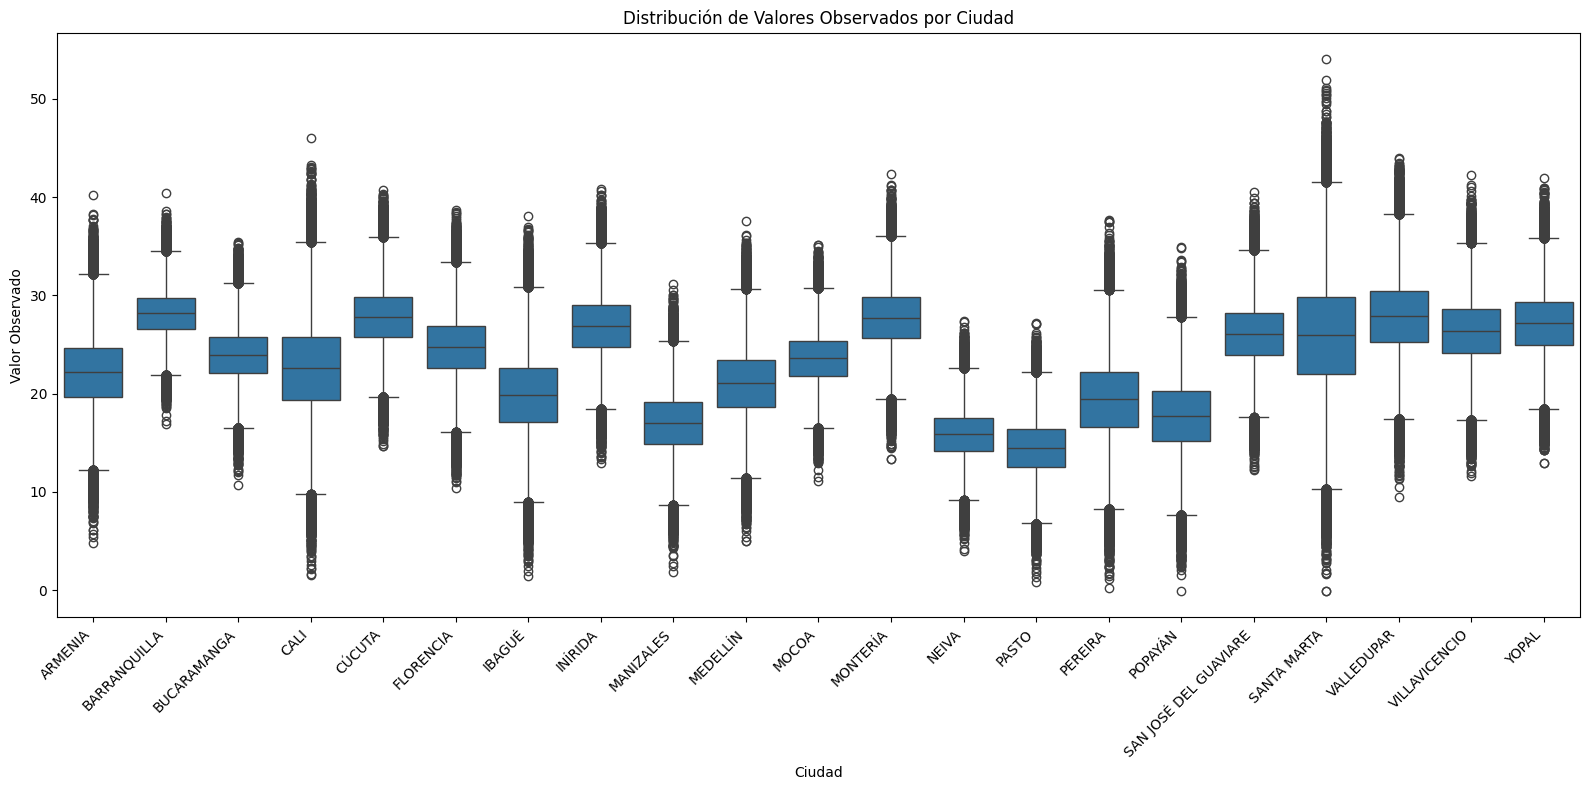

In [23]:

# Crear el gráfico de boxplot
plt.figure(figsize=(16, 8))
sns.boxplot(data=df_modelo, x='Ciudad', y='ValorObservado')  # Reemplaza 'Ciudad' y 'ValorObservado' si las columnas tienen nombres diferentes

# Configurar el gráfico
plt.title("Distribución de Valores Observados por Ciudad")
plt.ylabel("Valor Observado")
plt.xlabel("Ciudad")
plt.xticks(rotation=45, ha="right")

# Mostrar el gráfico
plt.tight_layout()
plt.show()


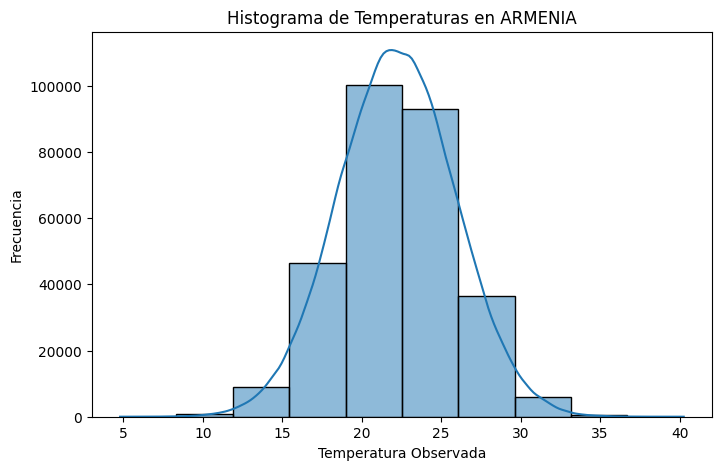

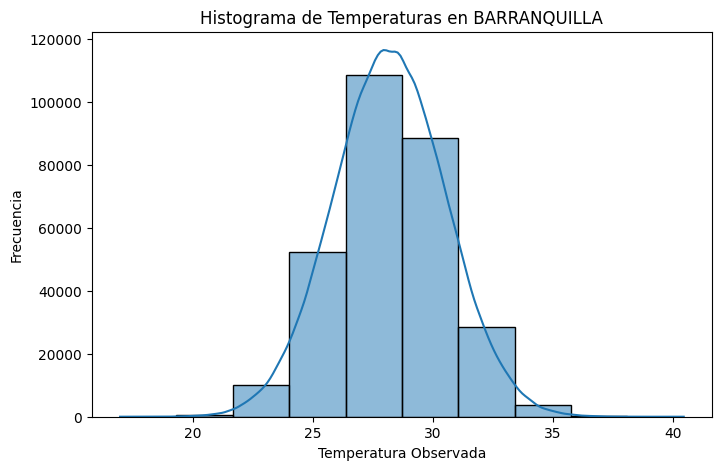

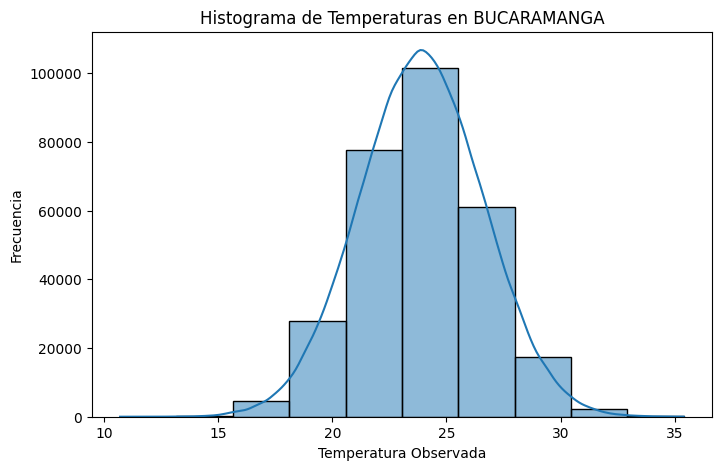

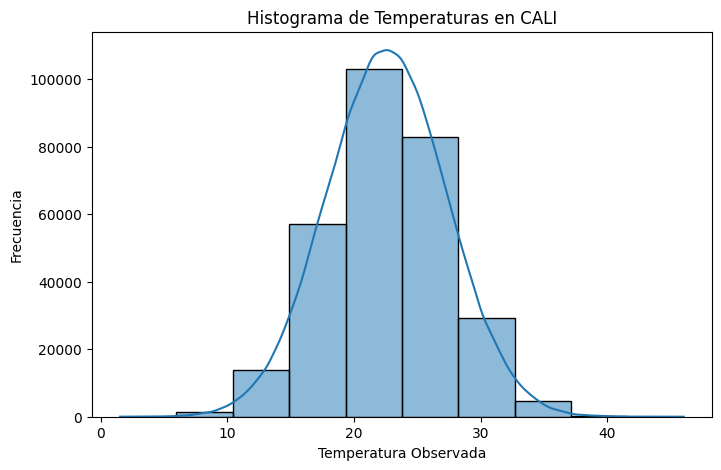

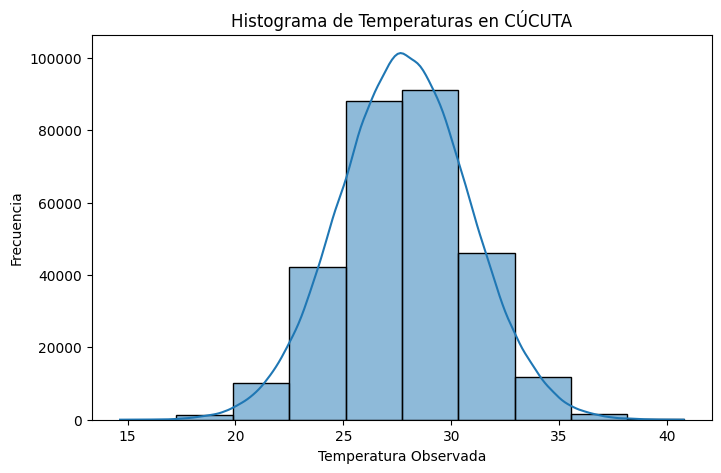

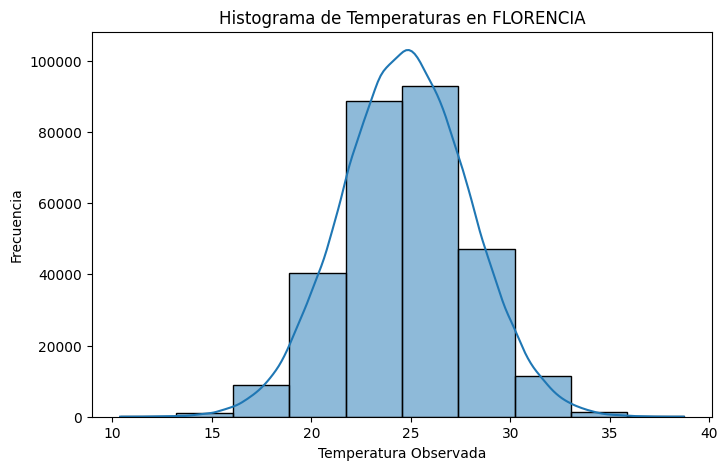

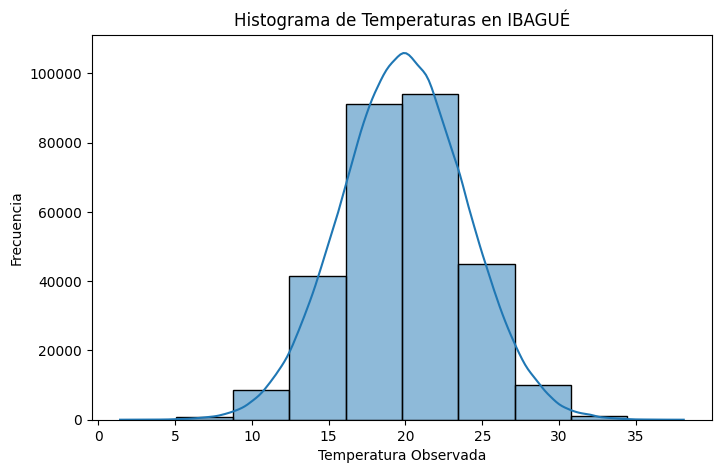

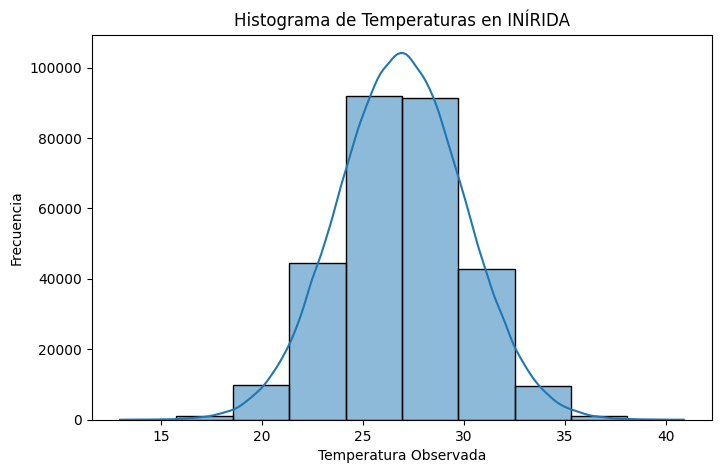

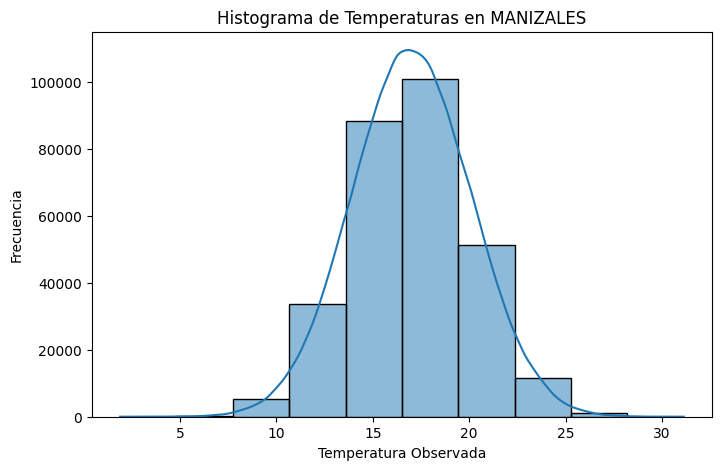

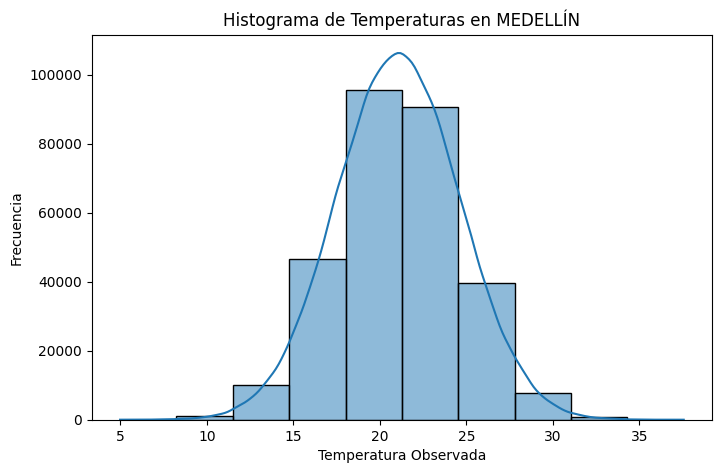

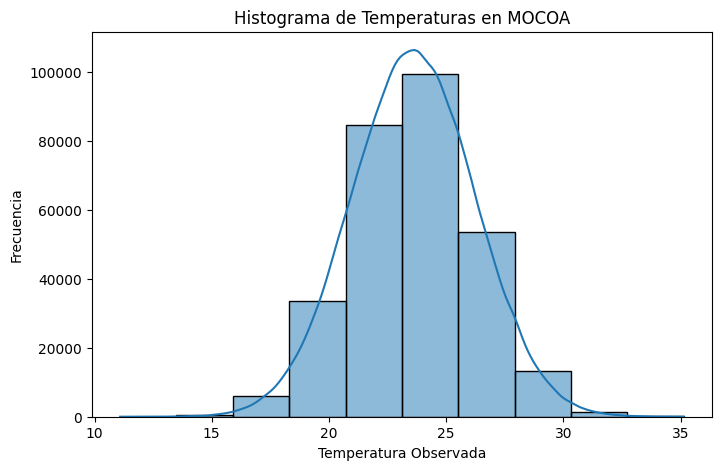

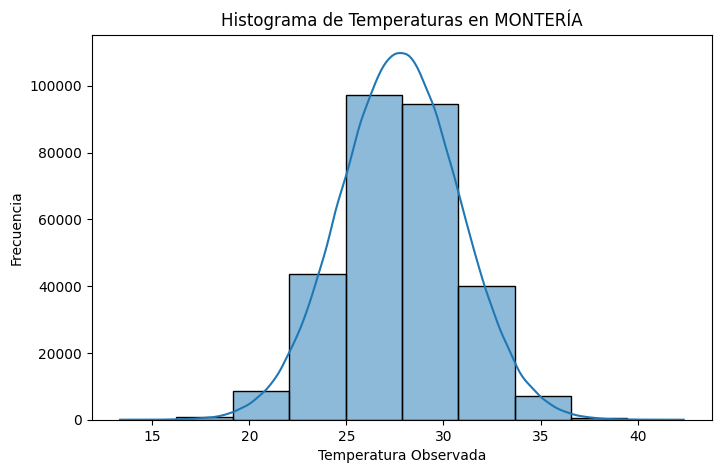

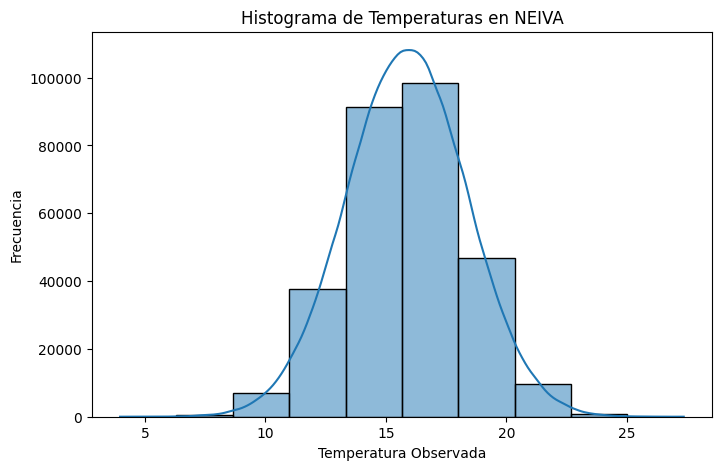

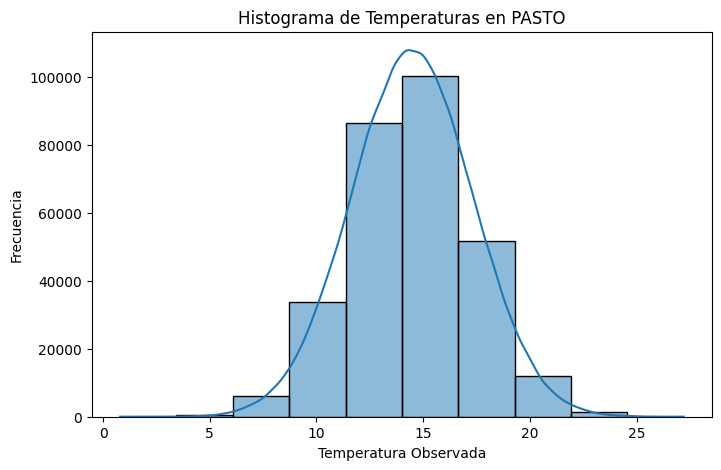

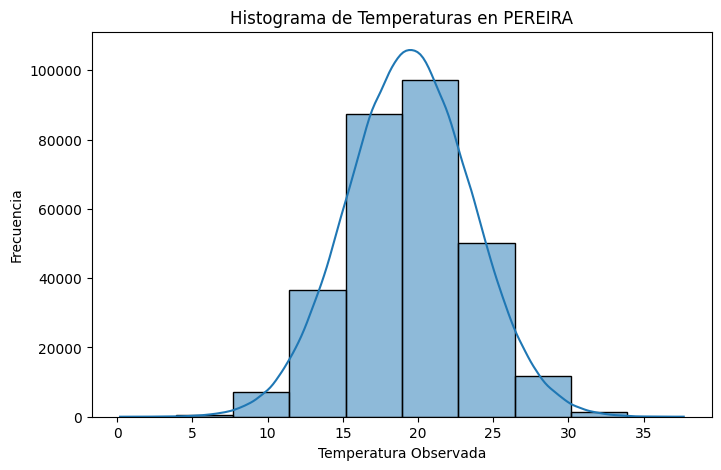

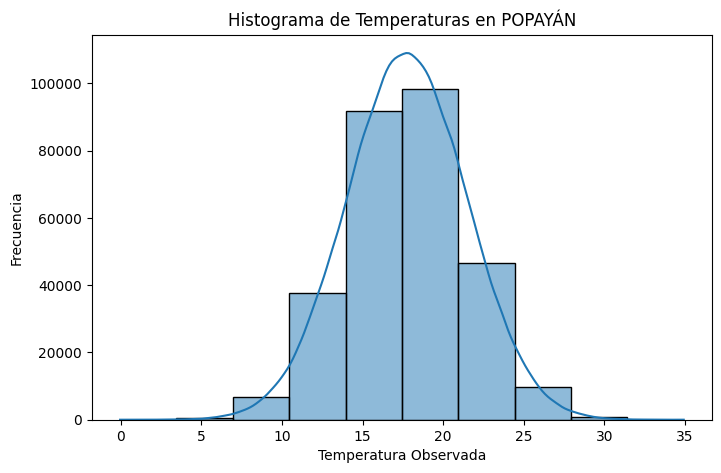

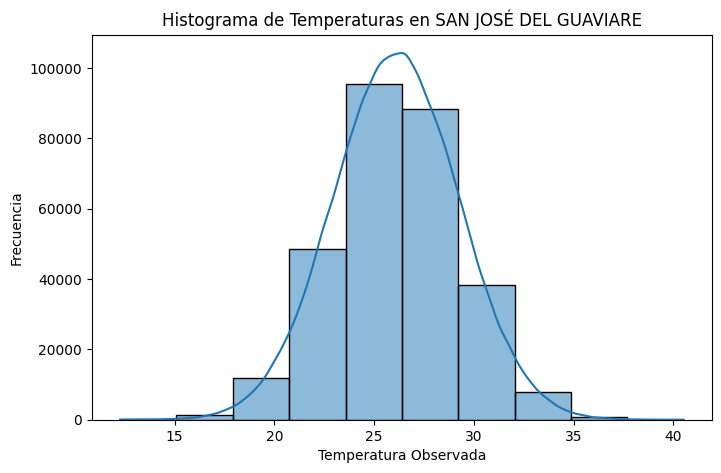

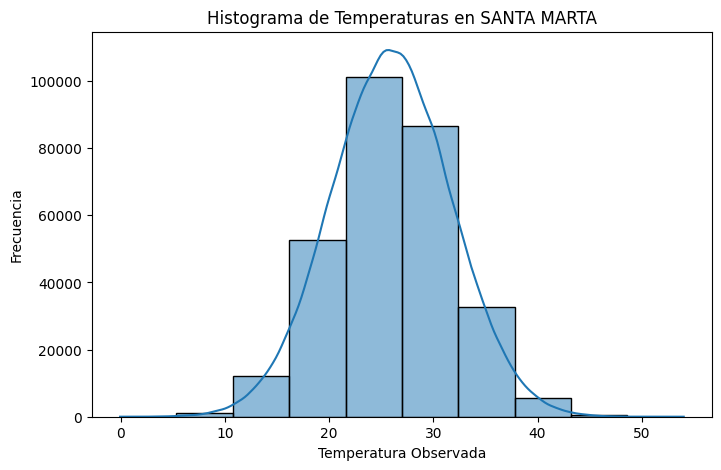

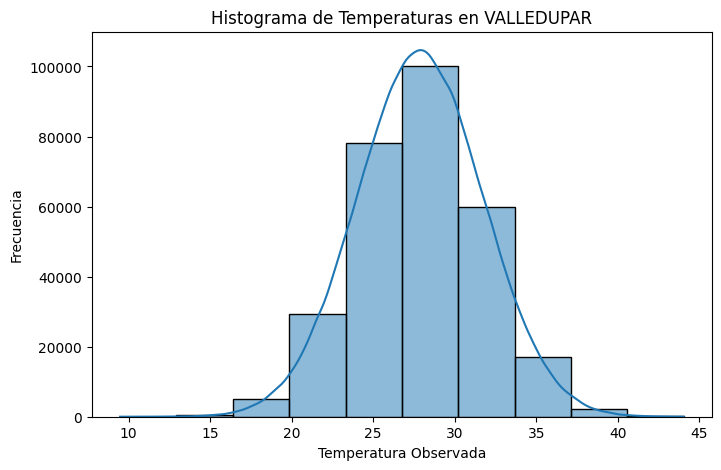

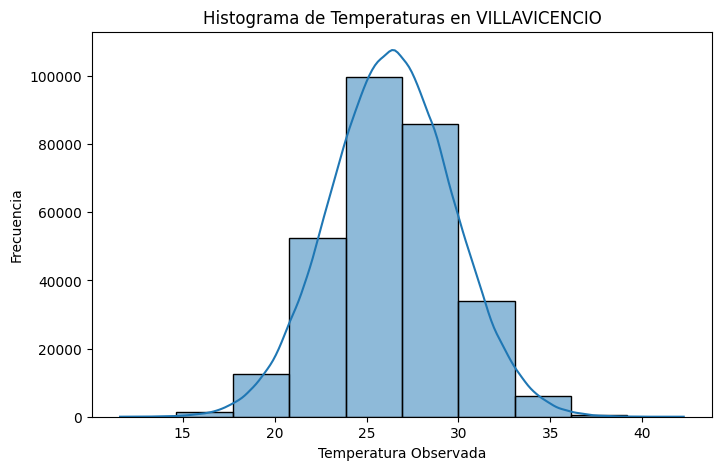

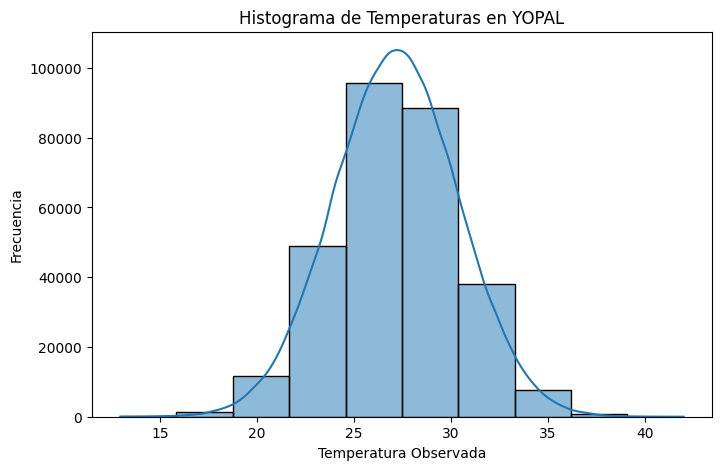

In [24]:
for ciudad in ciudades:
    # Filtrar los datos por ciudad
    datos_ciudad = df_modelo[df_modelo['Ciudad'] == ciudad]

    # Configurar el tamaño del gráfico
    plt.figure(figsize=(8, 5))

    # Crear el histograma para la ciudad actual
    sns.histplot(data=datos_ciudad, x='ValorObservado', bins=10, kde=True)

    # Añadir título y etiquetas
    plt.title(f'Histograma de Temperaturas en {ciudad}')
    plt.xlabel('Temperatura Observada')
    plt.ylabel('Frecuencia')

    # Mostrar el gráfico
    plt.show()

##Revision de eliminacion de Outliers

In [25]:
# Función para eliminar outliers usando el método IQR
def eliminar_outliers(df_modelo, columna_valor):
    Q1 = df_modelo[columna_valor].quantile(0.25)
    Q3 = df_modelo[columna_valor].quantile(0.75)
    IQR = Q3 - Q1
    # Filtrar valores que estén dentro del rango aceptable
    filtro = (df_modelo[columna_valor] >= (Q1 - 1.5 * IQR)) & (df_modelo[columna_valor] <= (Q3 + 1.5 * IQR))
    return df_modelo[filtro]

# Aplicar eliminación de outliers por cada ciudad
df_sin_outliers = df_modelo.groupby('Ciudad').apply(lambda x: eliminar_outliers(x, 'ValorObservado')).reset_index(drop=True)

print("Datos sin outliers:")
print(df_sin_outliers)


C:\Users\57319\AppData\Local\Temp\ipykernel_24076\509382974.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sin_outliers = df_modelo.groupby('Ciudad').apply(lambda x: eliminar_outliers(x, 'ValorObservado')).reset_index(drop=True)


Datos sin outliers:
                      FechaObservacion  ValorObservado   Ciudad
0        2012-01-01 01:58:00.000000000       23.277243  ARMENIA
1        2012-01-01 02:17:47.500761118       18.500586  ARMENIA
2        2012-01-01 02:37:35.001522236       18.728605  ARMENIA
3        2012-01-01 02:57:22.502283354       22.302668  ARMENIA
4        2012-01-01 03:17:10.003044473       25.286728  ARMENIA
...                                ...             ...      ...
6096512  2022-12-31 22:34:49.872166336       28.424203    YOPAL
6096513  2022-12-31 22:54:37.404124736       21.701133    YOPAL
6096514  2022-12-31 23:14:24.936083200       22.021022    YOPAL
6096515  2022-12-31 23:34:12.468041600       30.643728    YOPAL
6096516  2022-12-31 23:54:00.000000000       30.964157    YOPAL

[6096517 rows x 3 columns]


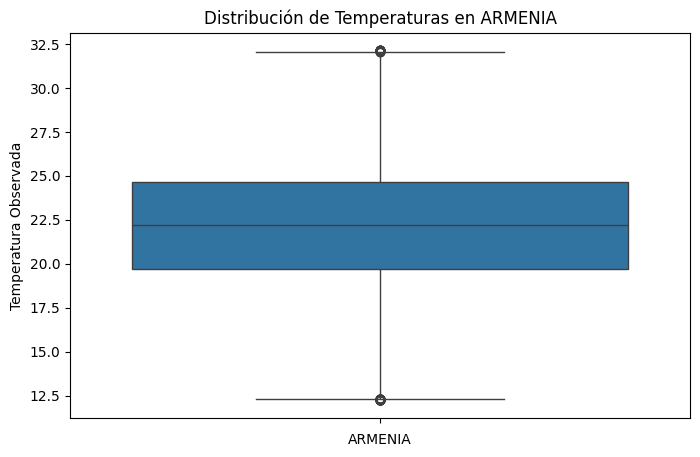

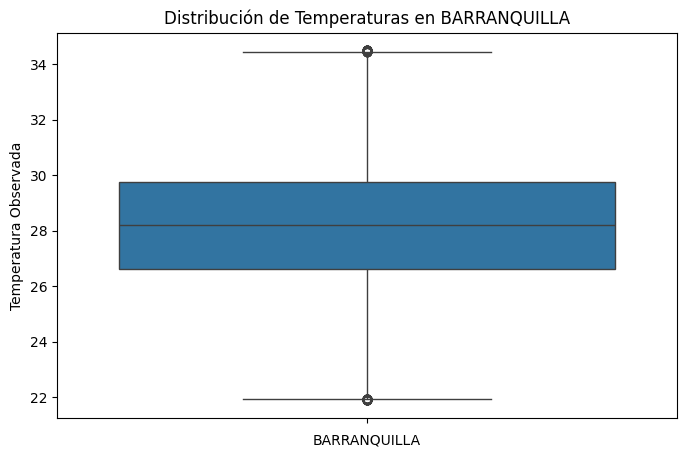

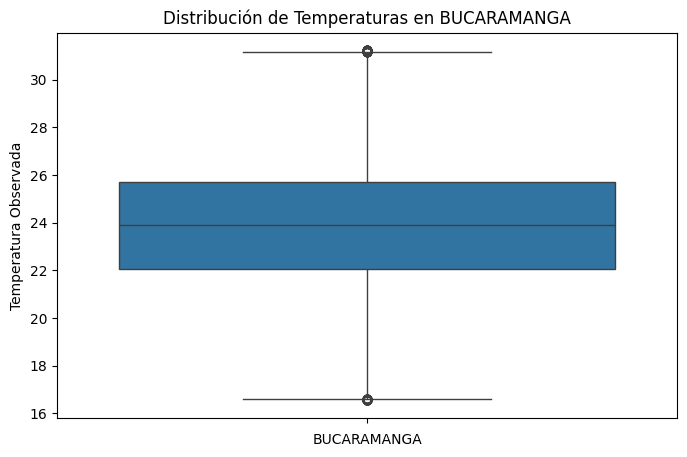

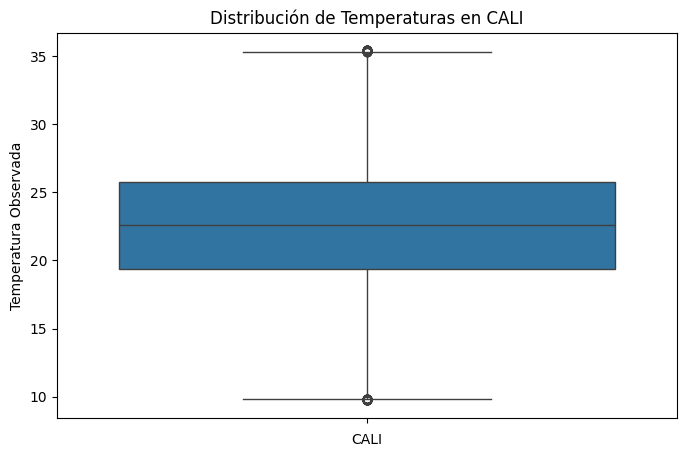

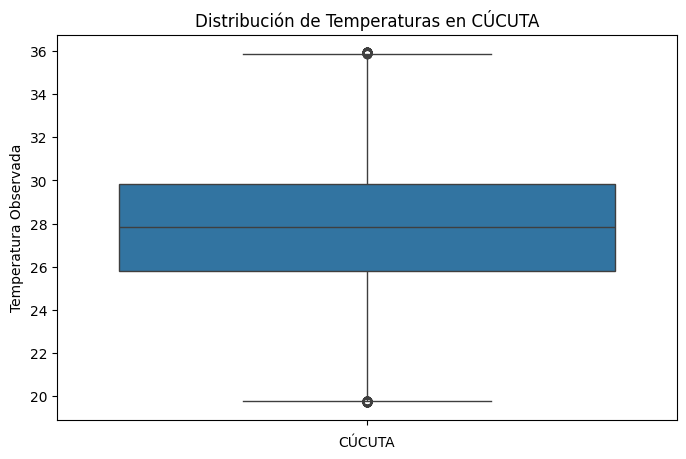

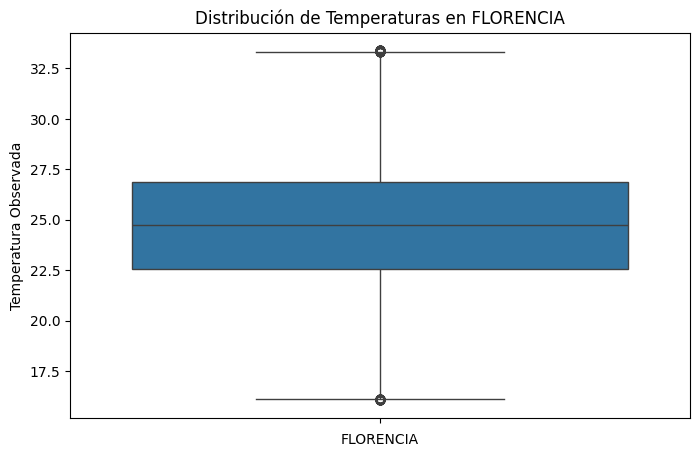

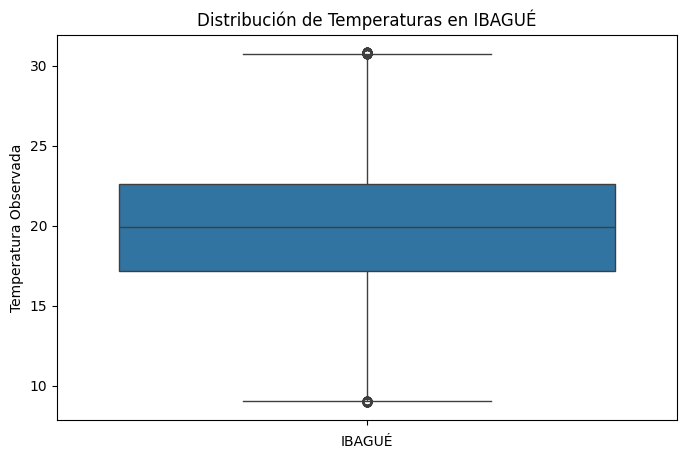

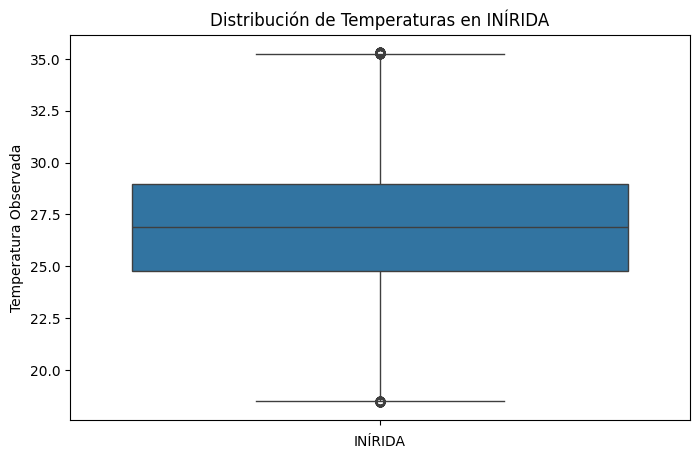

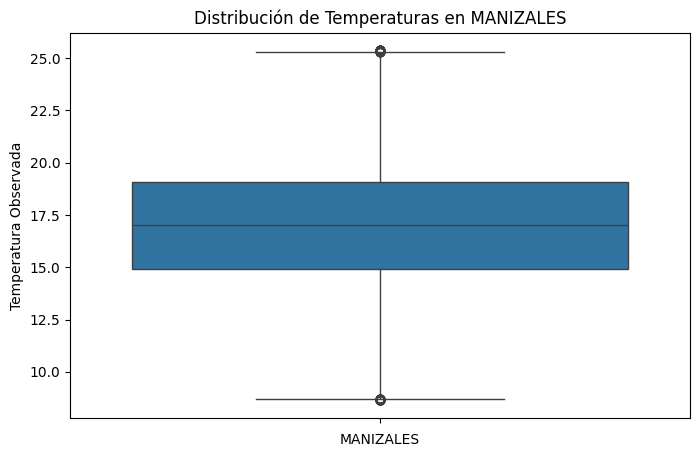

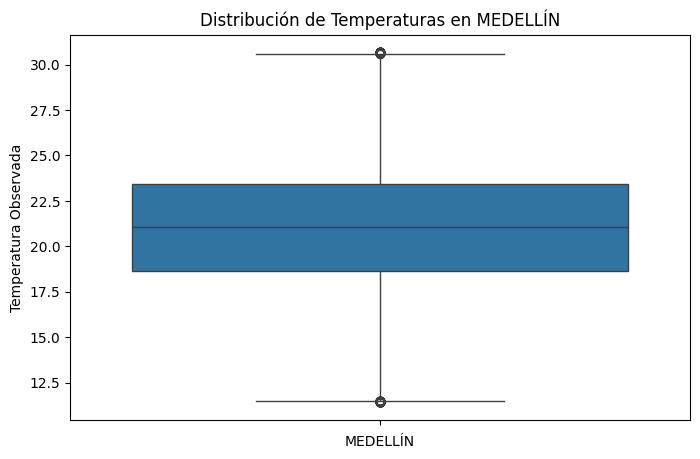

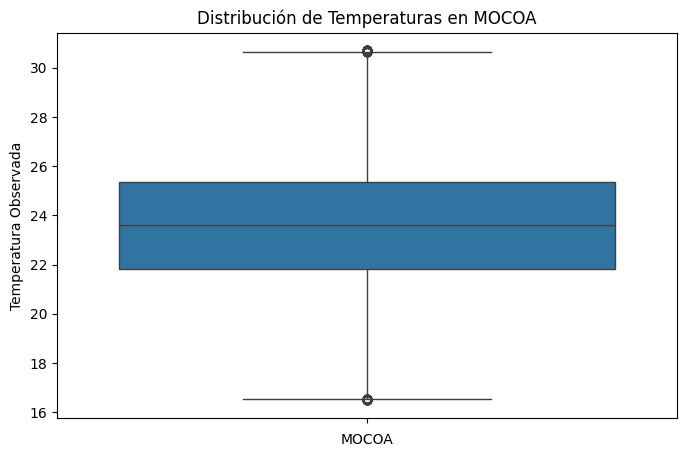

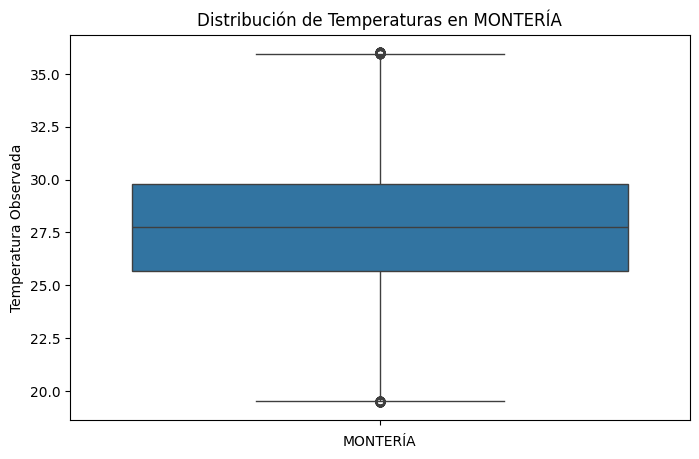

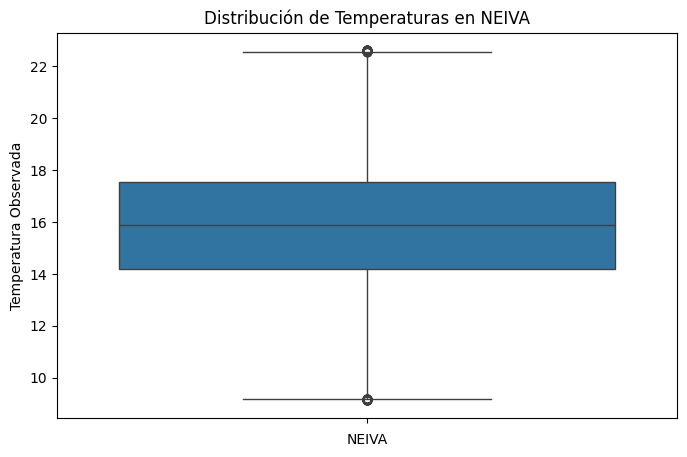

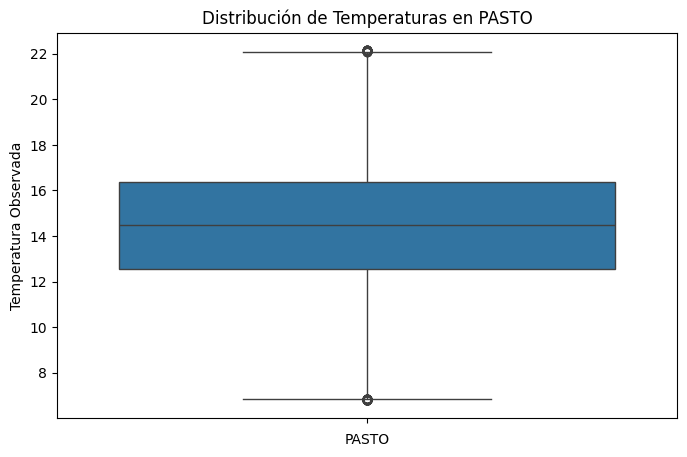

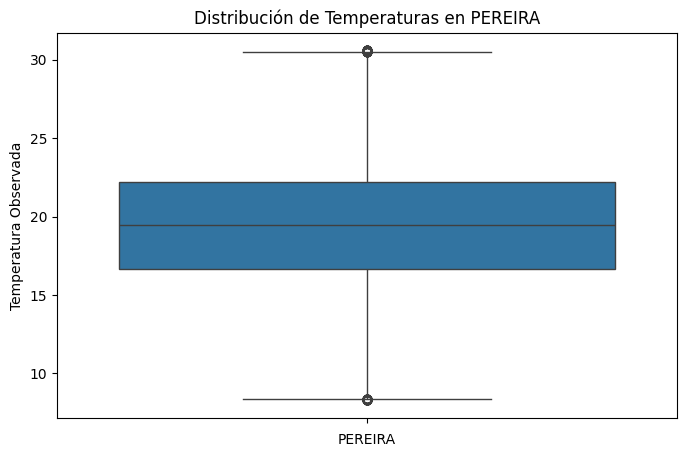

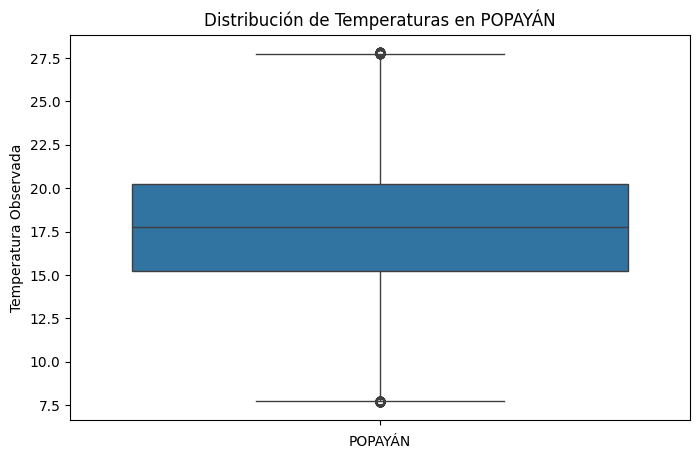

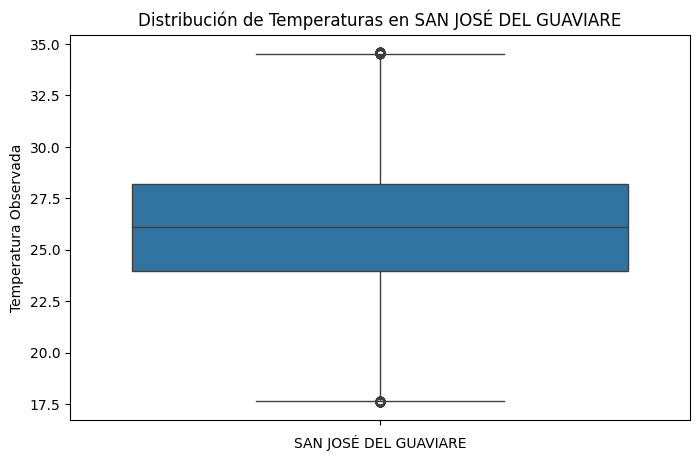

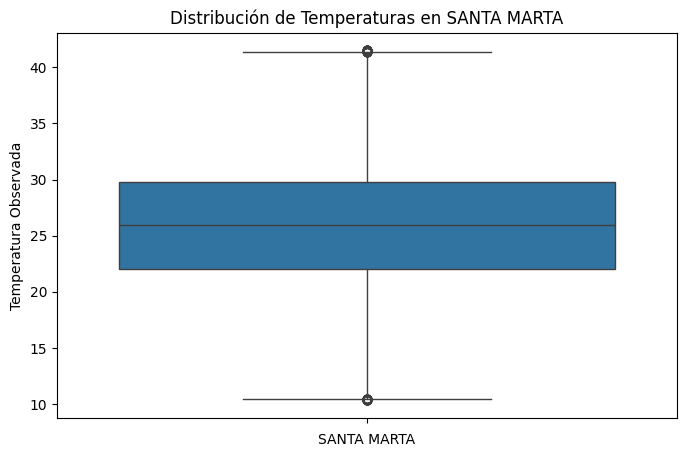

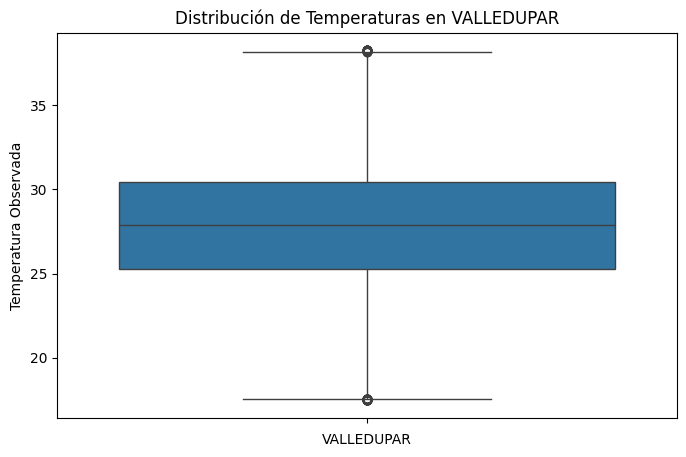

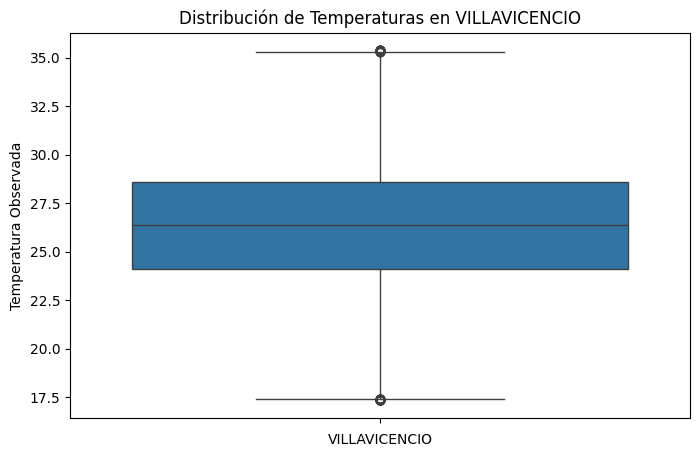

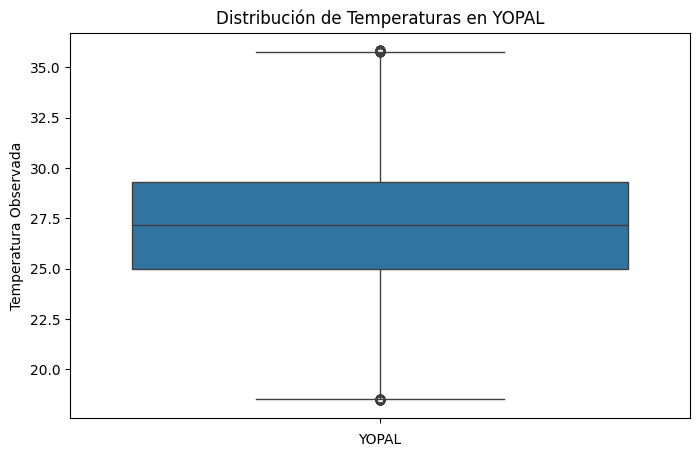

In [26]:
# Crear un boxplot para cada ciudad y mostrarlo en Python
for ciudad in ciudades:
    # Filtrar los datos por ciudad
    datos_ciudad = df_sin_outliers[df_sin_outliers['Ciudad'] == ciudad]

    # Configurar el tamaño del gráfico
    plt.figure(figsize=(8, 5))

    # Crear el boxplot para la ciudad actual
    sns.boxplot(data=datos_ciudad, y='ValorObservado')

    # Añadir título y etiquetas
    plt.title(f'Distribución de Temperaturas en {ciudad}')
    plt.ylabel('Temperatura Observada')
    plt.xlabel(ciudad)

    # Mostrar el gráfico
    plt.show()

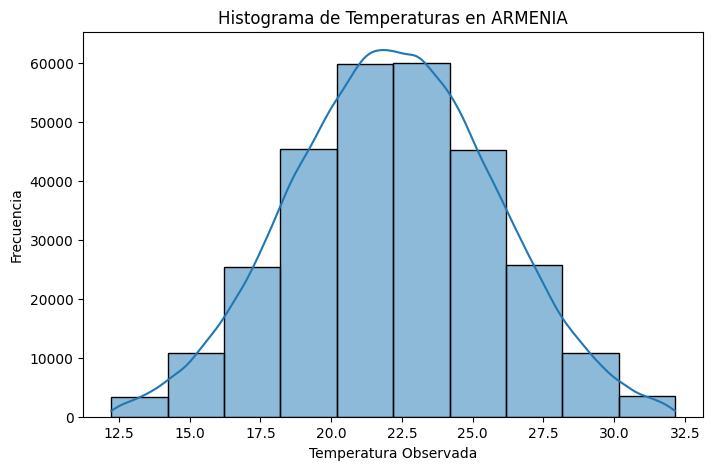

C:\Users\57319\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290366.
  res = hypotest_fun_out(*samples, **kwds)


Prueba de Shapiro-Wilk para ARMENIA:
  Estadístico W = 0.9985, Valor p = 0.0000
  Los datos de ARMENIA parecen seguir una distribución normal (p <= 0.05).



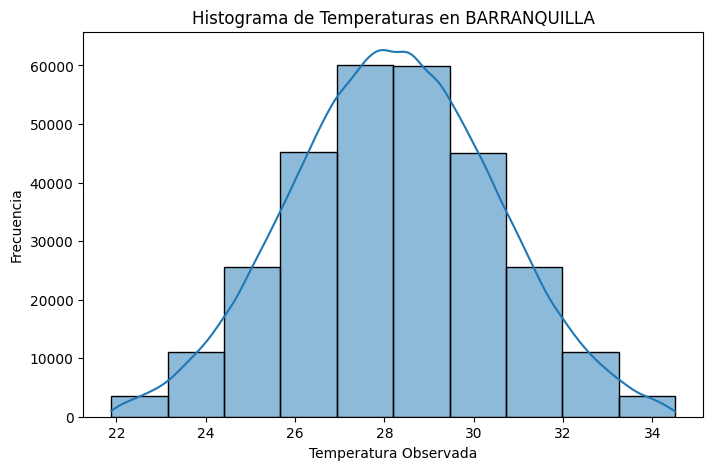

C:\Users\57319\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290343.
  res = hypotest_fun_out(*samples, **kwds)


Prueba de Shapiro-Wilk para BARRANQUILLA:
  Estadístico W = 0.9984, Valor p = 0.0000
  Los datos de BARRANQUILLA parecen seguir una distribución normal (p <= 0.05).



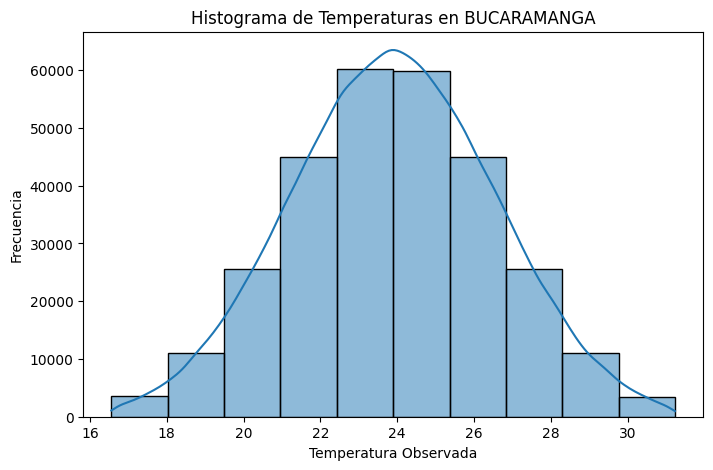

C:\Users\57319\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290276.
  res = hypotest_fun_out(*samples, **kwds)


Prueba de Shapiro-Wilk para BUCARAMANGA:
  Estadístico W = 0.9984, Valor p = 0.0000
  Los datos de BUCARAMANGA parecen seguir una distribución normal (p <= 0.05).



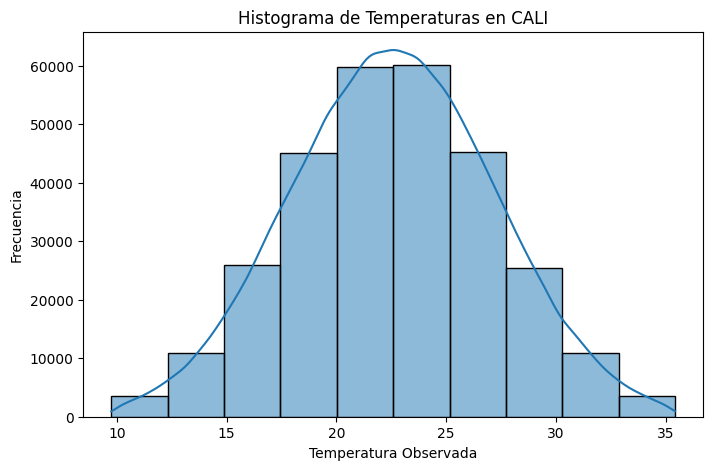

C:\Users\57319\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290370.
  res = hypotest_fun_out(*samples, **kwds)


Prueba de Shapiro-Wilk para CALI:
  Estadístico W = 0.9984, Valor p = 0.0000
  Los datos de CALI parecen seguir una distribución normal (p <= 0.05).



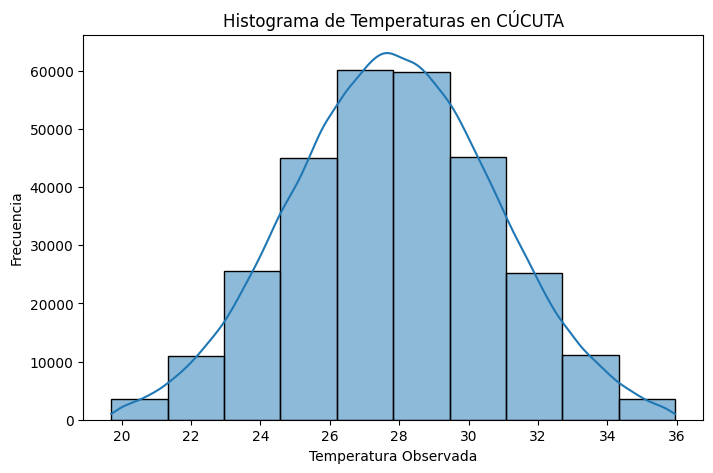

C:\Users\57319\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290187.
  res = hypotest_fun_out(*samples, **kwds)


Prueba de Shapiro-Wilk para CÚCUTA:
  Estadístico W = 0.9984, Valor p = 0.0000
  Los datos de CÚCUTA parecen seguir una distribución normal (p <= 0.05).



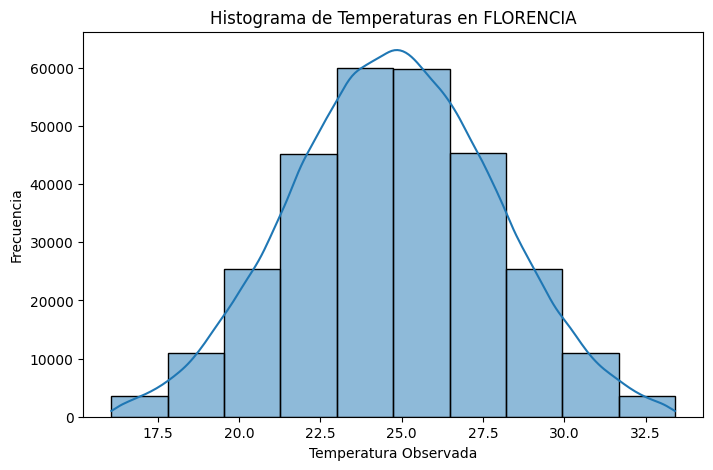

C:\Users\57319\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290220.
  res = hypotest_fun_out(*samples, **kwds)


Prueba de Shapiro-Wilk para FLORENCIA:
  Estadístico W = 0.9984, Valor p = 0.0000
  Los datos de FLORENCIA parecen seguir una distribución normal (p <= 0.05).



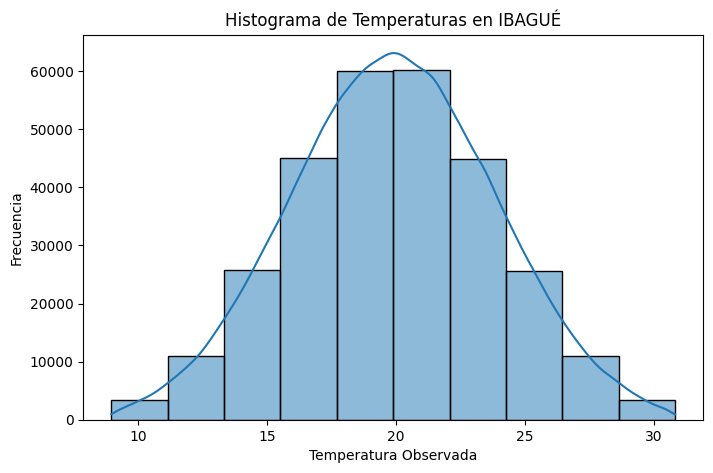

C:\Users\57319\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290292.
  res = hypotest_fun_out(*samples, **kwds)


Prueba de Shapiro-Wilk para IBAGUÉ:
  Estadístico W = 0.9983, Valor p = 0.0000
  Los datos de IBAGUÉ parecen seguir una distribución normal (p <= 0.05).



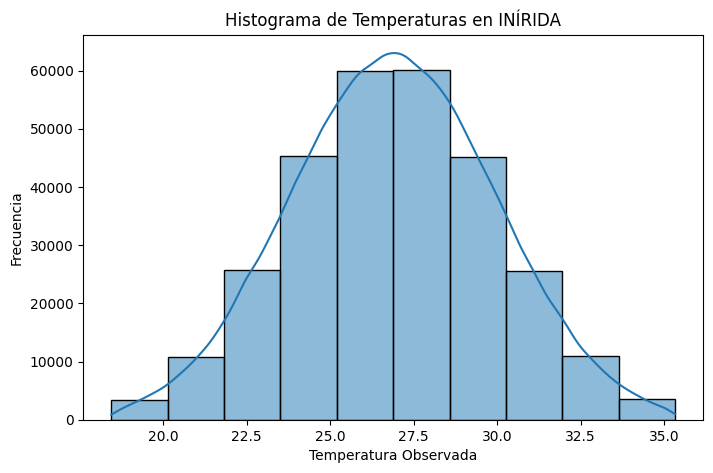

C:\Users\57319\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290242.
  res = hypotest_fun_out(*samples, **kwds)


Prueba de Shapiro-Wilk para INÍRIDA:
  Estadístico W = 0.9984, Valor p = 0.0000
  Los datos de INÍRIDA parecen seguir una distribución normal (p <= 0.05).



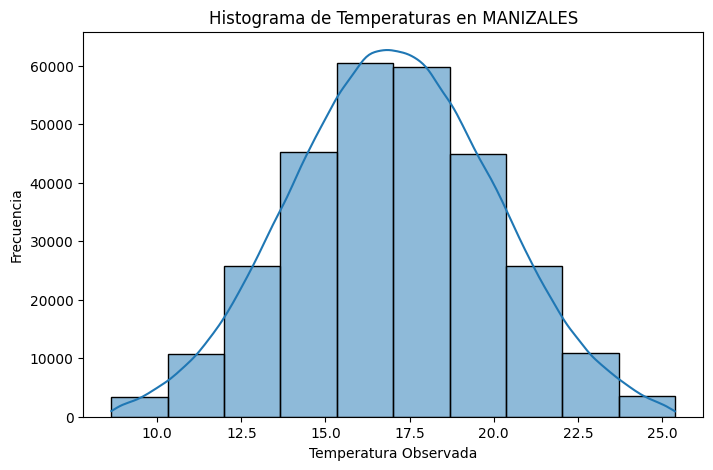

C:\Users\57319\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290341.
  res = hypotest_fun_out(*samples, **kwds)


Prueba de Shapiro-Wilk para MANIZALES:
  Estadístico W = 0.9984, Valor p = 0.0000
  Los datos de MANIZALES parecen seguir una distribución normal (p <= 0.05).



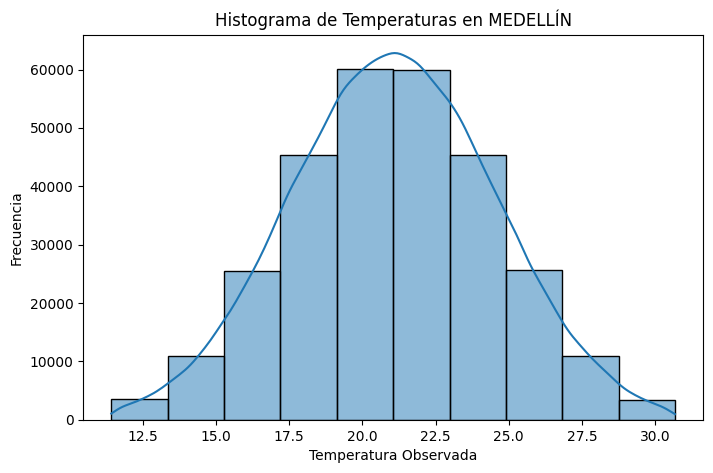

C:\Users\57319\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290413.
  res = hypotest_fun_out(*samples, **kwds)


Prueba de Shapiro-Wilk para MEDELLÍN:
  Estadístico W = 0.9984, Valor p = 0.0000
  Los datos de MEDELLÍN parecen seguir una distribución normal (p <= 0.05).



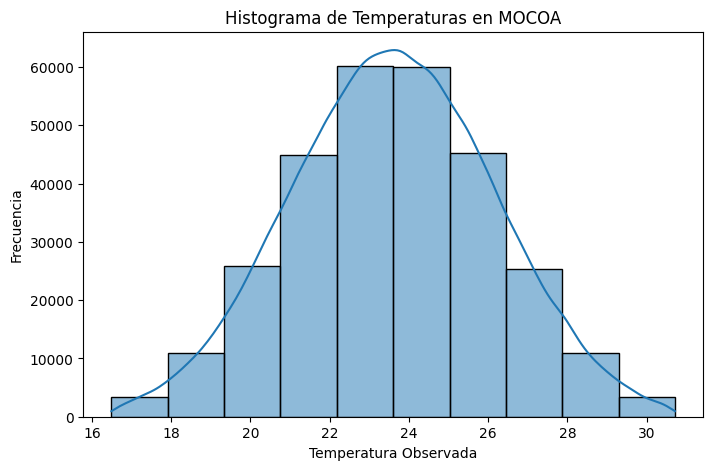

C:\Users\57319\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290349.
  res = hypotest_fun_out(*samples, **kwds)


Prueba de Shapiro-Wilk para MOCOA:
  Estadístico W = 0.9984, Valor p = 0.0000
  Los datos de MOCOA parecen seguir una distribución normal (p <= 0.05).



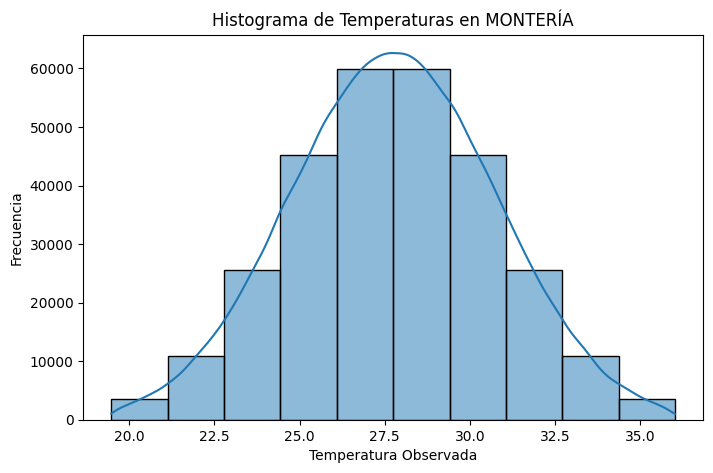

C:\Users\57319\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290323.
  res = hypotest_fun_out(*samples, **kwds)


Prueba de Shapiro-Wilk para MONTERÍA:
  Estadístico W = 0.9984, Valor p = 0.0000
  Los datos de MONTERÍA parecen seguir una distribución normal (p <= 0.05).



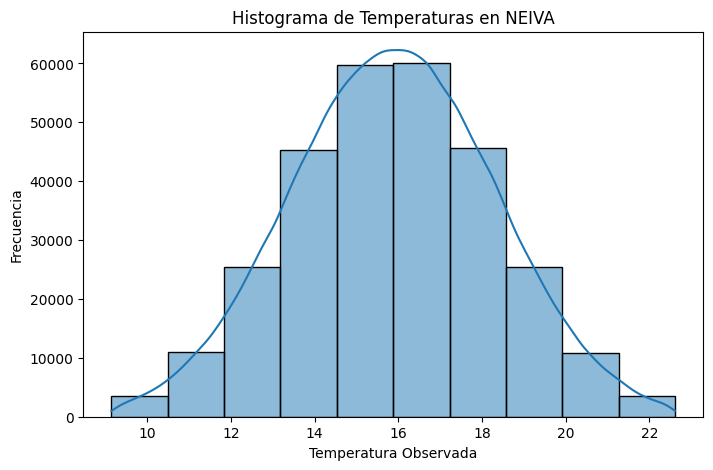

C:\Users\57319\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290291.
  res = hypotest_fun_out(*samples, **kwds)


Prueba de Shapiro-Wilk para NEIVA:
  Estadístico W = 0.9984, Valor p = 0.0000
  Los datos de NEIVA parecen seguir una distribución normal (p <= 0.05).



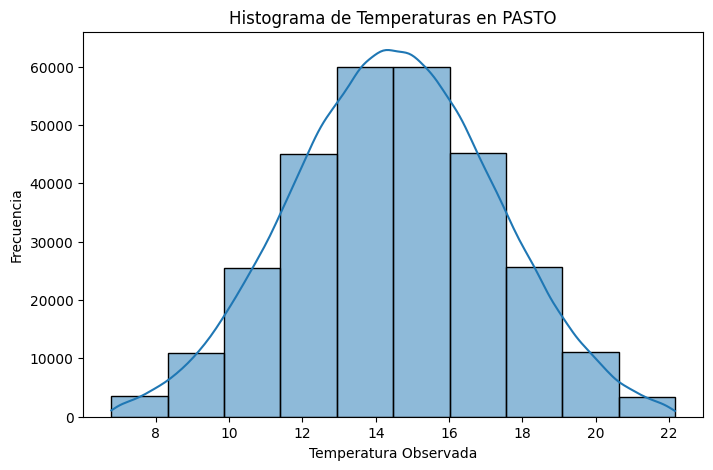

C:\Users\57319\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290315.
  res = hypotest_fun_out(*samples, **kwds)


Prueba de Shapiro-Wilk para PASTO:
  Estadístico W = 0.9984, Valor p = 0.0000
  Los datos de PASTO parecen seguir una distribución normal (p <= 0.05).



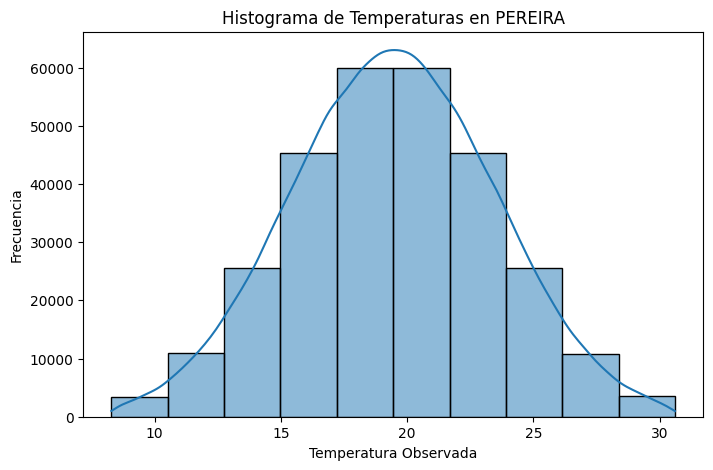

C:\Users\57319\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290266.
  res = hypotest_fun_out(*samples, **kwds)


Prueba de Shapiro-Wilk para PEREIRA:
  Estadístico W = 0.9984, Valor p = 0.0000
  Los datos de PEREIRA parecen seguir una distribución normal (p <= 0.05).



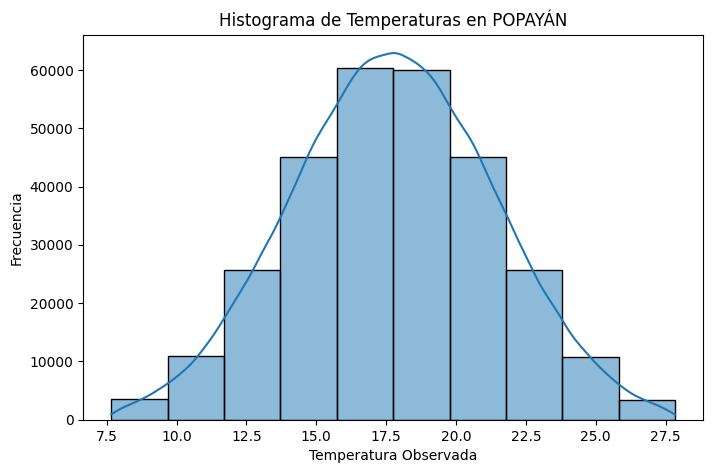

C:\Users\57319\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290327.
  res = hypotest_fun_out(*samples, **kwds)


Prueba de Shapiro-Wilk para POPAYÁN:
  Estadístico W = 0.9984, Valor p = 0.0000
  Los datos de POPAYÁN parecen seguir una distribución normal (p <= 0.05).



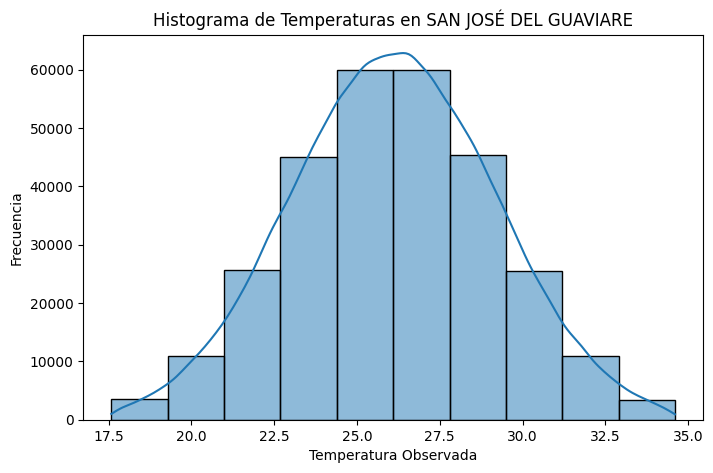

C:\Users\57319\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290329.
  res = hypotest_fun_out(*samples, **kwds)


Prueba de Shapiro-Wilk para SAN JOSÉ DEL GUAVIARE:
  Estadístico W = 0.9984, Valor p = 0.0000
  Los datos de SAN JOSÉ DEL GUAVIARE parecen seguir una distribución normal (p <= 0.05).



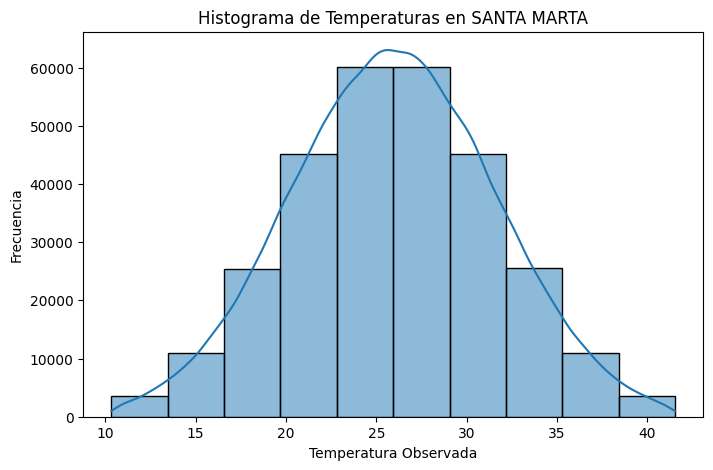

C:\Users\57319\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290287.
  res = hypotest_fun_out(*samples, **kwds)


Prueba de Shapiro-Wilk para SANTA MARTA:
  Estadístico W = 0.9984, Valor p = 0.0000
  Los datos de SANTA MARTA parecen seguir una distribución normal (p <= 0.05).



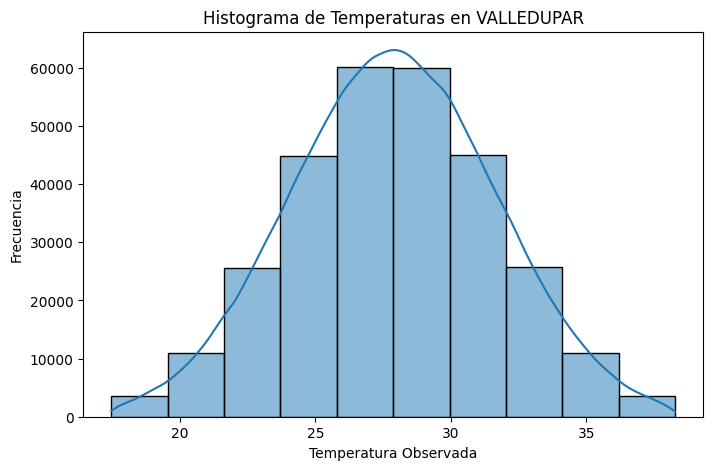

C:\Users\57319\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290332.
  res = hypotest_fun_out(*samples, **kwds)


Prueba de Shapiro-Wilk para VALLEDUPAR:
  Estadístico W = 0.9984, Valor p = 0.0000
  Los datos de VALLEDUPAR parecen seguir una distribución normal (p <= 0.05).



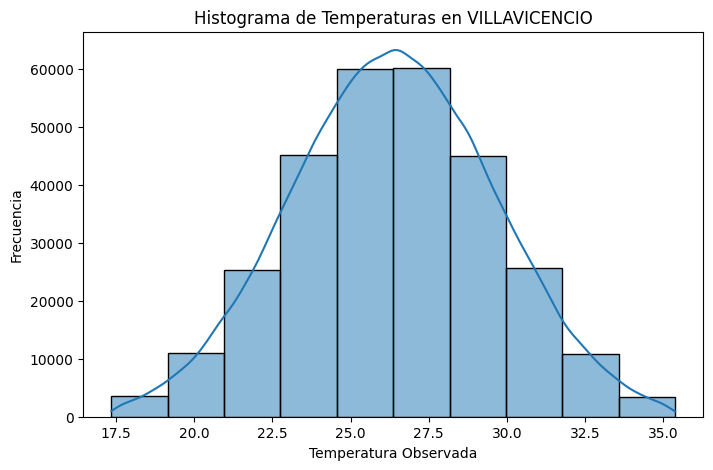

C:\Users\57319\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290383.
  res = hypotest_fun_out(*samples, **kwds)


Prueba de Shapiro-Wilk para VILLAVICENCIO:
  Estadístico W = 0.9984, Valor p = 0.0000
  Los datos de VILLAVICENCIO parecen seguir una distribución normal (p <= 0.05).



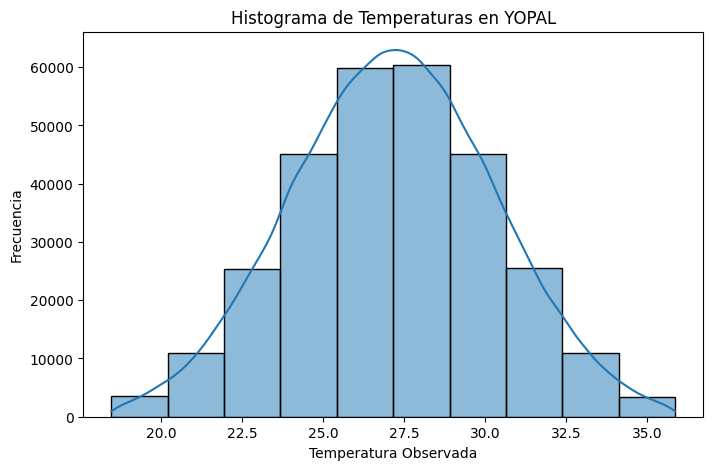

Prueba de Shapiro-Wilk para YOPAL:
  Estadístico W = 0.9984, Valor p = 0.0000
  Los datos de YOPAL parecen seguir una distribución normal (p <= 0.05).



C:\Users\57319\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290265.
  res = hypotest_fun_out(*samples, **kwds)


In [27]:

# Iterar por cada ciudad en el DataFrame
for ciudad in df_sin_outliers['Ciudad'].unique():
    # Filtrar los datos por ciudad
    datos_ciudad = df_sin_outliers[df_sin_outliers['Ciudad'] == ciudad]

    # Configurar el tamaño del gráfico
    plt.figure(figsize=(8, 5))

    # Crear el histograma para la ciudad actual
    sns.histplot(data=datos_ciudad, x='ValorObservado', bins=10, kde=True)

    # Añadir título y etiquetas
    plt.title(f'Histograma de Temperaturas en {ciudad}')
    plt.xlabel('Temperatura Observada')
    plt.ylabel('Frecuencia')

    # Mostrar el gráfico
    plt.show()

    # Realizar la prueba de Shapiro-Wilk
    stat, p = shapiro(datos_ciudad['ValorObservado'])
    print(f"Prueba de Shapiro-Wilk para {ciudad}:")
    print(f"  Estadístico W = {stat:.4f}, Valor p = {p:.4f}")
    
    # Interpretar el resultado
    if p > 0.05:
        print(f"  Los datos de {ciudad} parecen no seguir una distribución normal (p > 0.05).\n")
    else:
        print(f"  Los datos de {ciudad} parecen seguir una distribución normal (p <= 0.05).\n")


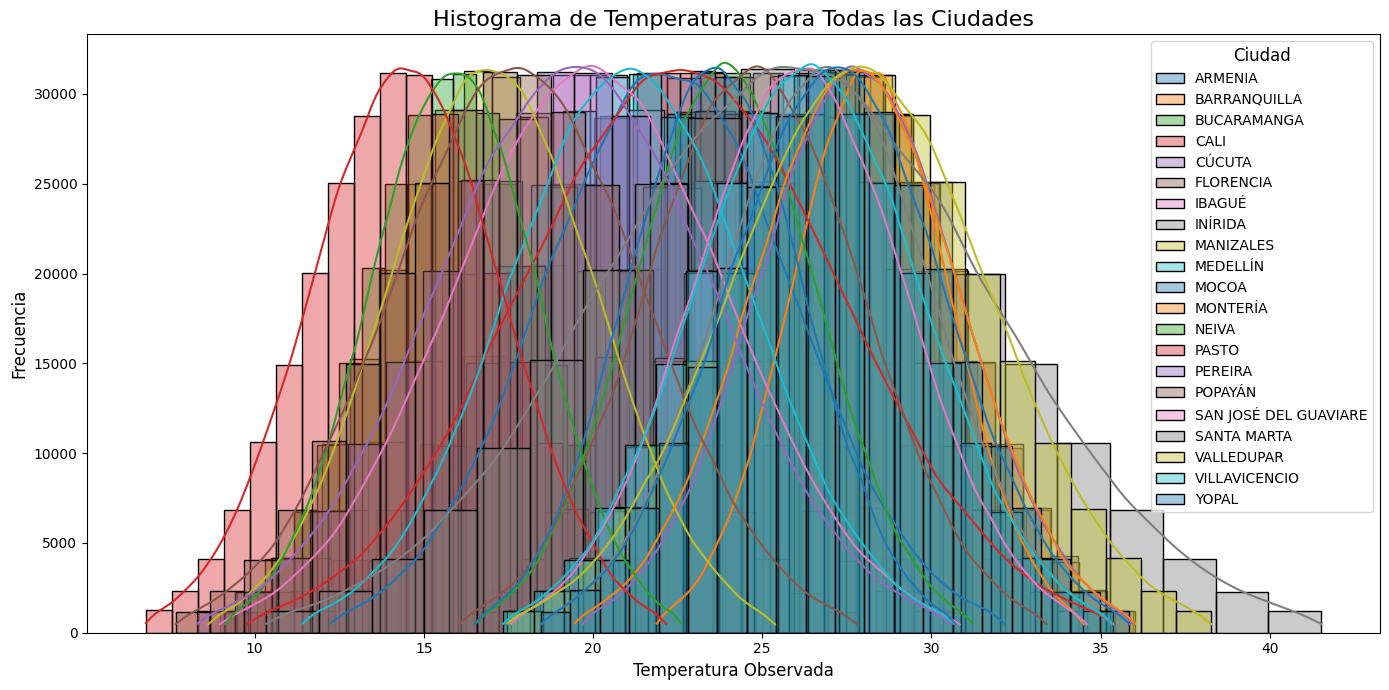

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el tamaño del gráfico
plt.figure(figsize=(14, 7))

# Colores para distinguir las ciudades
palette = sns.color_palette("tab10", len(ciudades))

# Crear el gráfico con los datos de todas las ciudades
for i, ciudad in enumerate(ciudades):
    # Filtrar los datos por ciudad
    datos_ciudad = df_sin_outliers[df_sin_outliers['Ciudad'] == ciudad]

    # Añadir el histograma de la ciudad actual al gráfico
    sns.histplot(
        data=datos_ciudad,
        x='ValorObservado',
        bins=20,  # Ajusta el número de bins
        kde=True,
        label=f"{ciudad}",
        color=palette[i],
        alpha=0.4,  # Aumenta la transparencia para superposiciones claras
        line_kws={"lw": 1.5}  # Ajusta el grosor de las líneas KDE
    )

# Añadir título y etiquetas
plt.title('Histograma de Temperaturas para Todas las Ciudades', fontsize=16)
plt.xlabel('Temperatura Observada', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# Añadir una leyenda con los nombres de las ciudades
plt.legend(title="Ciudad", loc='upper right', fontsize=10, title_fontsize=12)

# Ajustar márgenes y mostrar el gráfico
plt.tight_layout()
plt.show()


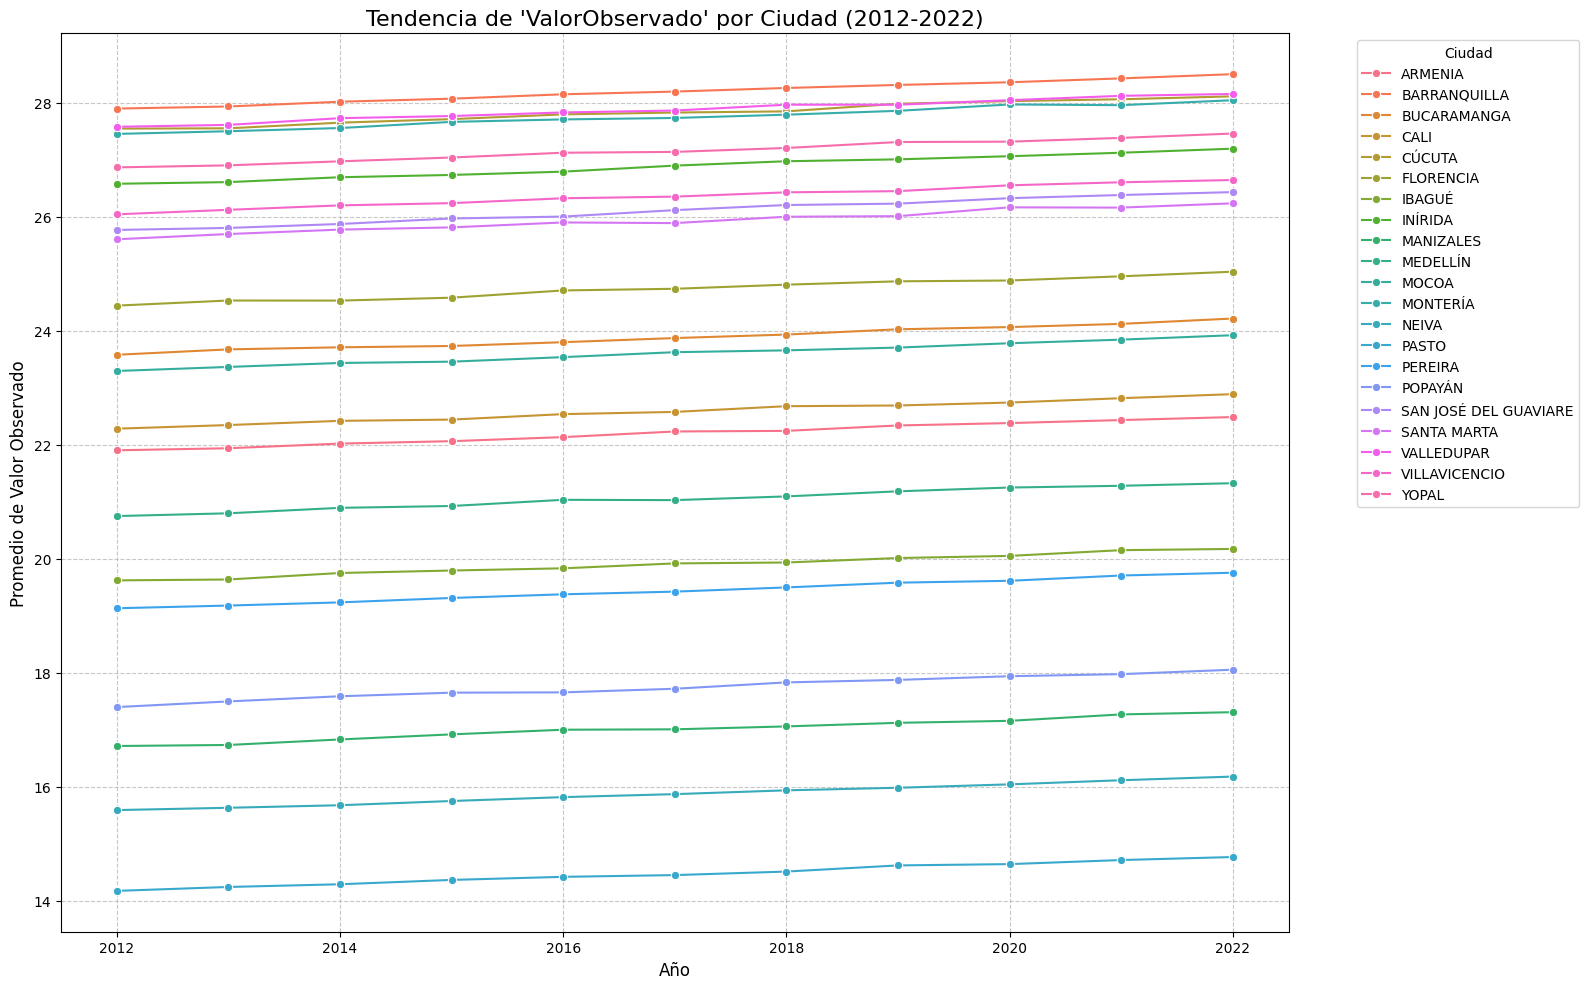

In [29]:
# Asegúrate de que la columna 'FechaObservacion' sea de tipo datetime
df_sin_outliers["FechaObservacion"] = pd.to_datetime(df_sin_outliers["FechaObservacion"], errors='coerce')

# Filtrar los datos entre 2012 y 2022
new_df_cleaned = df_sin_outliers[(df_sin_outliers["FechaObservacion"].dt.year >= 2012) & 
                                (df_sin_outliers["FechaObservacion"].dt.year <= 2022)]

# Añadir una columna de 'Year' para agrupar
new_df_cleaned["Year"] = new_df_cleaned["FechaObservacion"].dt.year

# Agrupar por Ciudad y Año, calculando la media de 'ValorObservado'
trend_data = new_df_cleaned.groupby(["Ciudad", "Year"])["ValorObservado"].mean().reset_index()

# Graficar las líneas de tendencia para cada ciudad
plt.figure(figsize=(16, 10))
sns.lineplot(data=trend_data, x="Year", y="ValorObservado", hue="Ciudad", marker="o")

# Personalizar el gráfico
plt.title("Tendencia de 'ValorObservado' por Ciudad (2012-2022)", fontsize=16)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Promedio de Valor Observado", fontsize=12)
plt.legend(title="Ciudad", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


Conteo de registros por ciudad

In [30]:
# Contar observaciones por ciudad usando groupby
conteo_observaciones = df_sin_outliers.groupby('Ciudad').size()

# Mostrar resultado
print("Número de observaciones por ciudad:")
print(conteo_observaciones)

Número de observaciones por ciudad:
Ciudad
ARMENIA                  290366
BARRANQUILLA             290343
BUCARAMANGA              290276
CALI                     290370
CÚCUTA                   290187
FLORENCIA                290220
IBAGUÉ                   290292
INÍRIDA                  290242
MANIZALES                290341
MEDELLÍN                 290413
MOCOA                    290349
MONTERÍA                 290323
NEIVA                    290291
PASTO                    290315
PEREIRA                  290266
POPAYÁN                  290327
SAN JOSÉ DEL GUAVIARE    290329
SANTA MARTA              290287
VALLEDUPAR               290332
VILLAVICENCIO            290383
YOPAL                    290265
dtype: int64


In [31]:
df_sin_outliers['FechaObservacion'] = pd.to_datetime(df_sin_outliers['FechaObservacion'])

# Extraer el año de la columna 'Fecha'
df_sin_outliers['Año'] = df_sin_outliers['FechaObservacion'].dt.year

# Obtener el primer y último año
primer_ano = df_sin_outliers['Año'].min()
ultimo_ano = df_sin_outliers['Año'].max()

# Filtrar los datos para el primer año
primer_ano_df = df_sin_outliers[df_sin_outliers['Año'] == primer_ano]

# Filtrar los datos para el último año
ultimo_ano_df = df_sin_outliers[df_sin_outliers['Año'] == ultimo_ano]

# Mostrar los resultados
print("Datos del primer año (", primer_ano, "):")
print(primer_ano_df)

print("\nDatos del último año (", ultimo_ano, "):")
print(ultimo_ano_df)

Datos del primer año ( 2012 ):
                     FechaObservacion  ValorObservado   Ciudad   Año
0       2012-01-01 01:58:00.000000000       23.277243  ARMENIA  2012
1       2012-01-01 02:17:47.500761118       18.500586  ARMENIA  2012
2       2012-01-01 02:37:35.001522236       18.728605  ARMENIA  2012
3       2012-01-01 02:57:22.502283354       22.302668  ARMENIA  2012
4       2012-01-01 03:17:10.003044473       25.286728  ARMENIA  2012
...                               ...             ...      ...   ...
5832671 2012-12-31 22:28:30.860901780       24.966385    YOPAL  2012
5832672 2012-12-31 22:48:18.392860196       30.258936    YOPAL  2012
5832673 2012-12-31 23:08:05.924818616       27.396516    YOPAL  2012
5832674 2012-12-31 23:27:53.456777032       29.466197    YOPAL  2012
5832675 2012-12-31 23:47:40.988735448       25.340631    YOPAL  2012

[512875 rows x 4 columns]

Datos del último año ( 2022 ):
                     FechaObservacion  ValorObservado   Ciudad   Año
264007  2022-

In [32]:
# Calcular las estadísticas para el primer año
estadisticas_primer_ano = primer_ano_df.groupby('Ciudad')['ValorObservado'].agg(
    Maxima='max',
    Minima='min',
    Promedio='mean',
    Mediana='median'
)

# Calcular las estadísticas para el último año
estadisticas_ultimo_ano = ultimo_ano_df.groupby('Ciudad')['ValorObservado'].agg(
    Maxima='max',
    Minima='min',
    Promedio='mean',
    Mediana='median'
)

In [33]:
estadisticas_ultimo_ano = estadisticas_ultimo_ano.reset_index()
estadisticas_primer_ano = estadisticas_primer_ano.reset_index()

In [34]:
estadisticas_primer_ano

Ciudad     Maxima     Minima   Promedio    Mediana
0                 ARMENIA  32.125086  12.235026  21.903624  21.901637
1            BARRANQUILLA  34.489870  21.892134  27.897342  27.876765
2             BUCARAMANGA  31.222009  16.558411  23.579163  23.576390
3                    CALI  35.373157   9.754957  22.282819  22.246497
4                  CÚCUTA  35.942672  19.721745  27.546093  27.556078
5               FLORENCIA  33.400496  16.077915  24.441234  24.440111
6                  IBAGUÉ  30.809396   8.968899  19.621621  19.613053
7                 INÍRIDA  35.320527  18.463547  26.578601  26.551013
8               MANIZALES  25.380636   8.649597  16.716576  16.699778
9                MEDELLÍN  30.674461  11.424577  20.749719  20.718571
10                  MOCOA  30.711310  16.509699  23.294632  23.284578
11               MONTERÍA  36.024411  19.470139  27.453209  27.448522
12                  NEIVA  22.613716   9.149391  15.592341  15.591167
13                  PASTO  22.149383   6.805714  14.175143  14.168445
14                PEREIRA  30.558685   8.311361  19.132889  19.109898
15                POPAYÁN  27.836274   7.674265  17.399224  17.391811
16  SAN JOSÉ DEL GUAVIARE  34.580300  17.581988  25.768568  25.786133
17            SANTA MARTA  41.498476  10.345384  25.604843  25.602562
18             VALLEDUPAR  38.243312  17.473664  27.578138  27.566600
19          VILLAVICENCIO  35.371197  17.351263  26.042733  26.059683
20                  YOPAL  35.833200  18.463084  26.865871  26.857431

In [35]:
estadisticas_ultimo_ano

Ciudad     Maxima     Minima   Promedio    Mediana
0                 ARMENIA  32.142891  12.253779  22.486460  22.477507
1            BARRANQUILLA  34.502712  21.898628  28.500989  28.518661
2             BUCARAMANGA  31.231665  16.558204  24.214711  24.196702
3                    CALI  35.414918   9.750751  22.888320  22.878473
4                  CÚCUTA  35.937129  19.705244  28.112329  28.129246
5               FLORENCIA  33.400354  16.070631  25.035943  25.034618
6                  IBAGUÉ  30.814129   8.992728  20.173167  20.205517
7                 INÍRIDA  35.323040  18.456373  27.193940  27.213106
8               MANIZALES  25.382038   8.650298  17.309671  17.309291
9                MEDELLÍN  30.676091  11.434736  21.326169  21.321470
10                  MOCOA  30.708970  16.489696  23.922090  23.920763
11               MONTERÍA  36.023533  19.477290  28.044090  28.071190
12                  NEIVA  22.605709   9.138909  16.180272  16.185023
13                  PASTO  22.158668   6.808231  14.768964  14.790412
14                PEREIRA  30.601339   8.293404  19.755743  19.765087
15                POPAYÁN  27.813830   7.683834  18.054685  18.033896
16  SAN JOSÉ DEL GUAVIARE  34.595463  17.851695  26.432237  26.362995
17            SANTA MARTA  41.510392  10.341780  26.235162  26.258421
18             VALLEDUPAR  38.269555  17.479795  28.153749  28.175735
19          VILLAVICENCIO  35.377719  17.372336  26.644257  26.658403
20                  YOPAL  35.840172  18.462411  27.459567  27.475187

**Pre-Procesamiento para Torneo de Modelos**

In [36]:
np.seterr(all='ignore')  # Ignora todas las advertencias numéricas

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [37]:
data = estadisticas_primer_ano[['Mediana']].values
data = estadisticas_ultimo_ano[['Mediana']].values

In [38]:
# Función para calcular métricas
def evaluate_model(labels, data):
    silhouette = silhouette_score(data, labels) if len(set(labels)) > 1 else np.nan
    dbi = davies_bouldin_score(data, labels) if len(set(labels)) > 1 else np.nan
    return silhouette, dbi

In [39]:
# Almacenar resultados
gridsearch_results = []

##Torneo de Modelos Primer Año (2012)

## Primer Modelo: K-MEANS

Grid Search para K-Means

In [40]:
best_kmeans = None
best_kmeans_score = -1
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data)
    silhouette, dbi = evaluate_model(labels, data)
    gridsearch_results.append(("K-means", k, silhouette, dbi))
    if silhouette > best_kmeans_score:
        best_kmeans_score = silhouette
        best_kmeans = (kmeans, labels)

##Segundo Modelo: Gaussian Mixture

Grid Search para Gaussian Mixture

In [41]:
best_gmm = None
best_gmm_score = -1
for n_components, covariance_type in product(range(2, 6), ['full', 'diag']):
    gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
    labels = gmm.fit_predict(data)
    silhouette, dbi = evaluate_model(labels, data)
    gridsearch_results.append(("GMM", (n_components, covariance_type), silhouette, dbi))
    if silhouette > best_gmm_score:
        best_gmm_score = silhouette
        best_gmm = (gmm, labels)

##Tercer Modelo: Agglomerative Clustering

Grid Search para Agglomerative Clustering

In [42]:
best_agglo = None
best_agglo_score = -1
for k, linkage in product(range(2, 6), ['ward', 'complete', 'average']):
    agglo = AgglomerativeClustering(n_clusters=k, linkage=linkage)
    labels = agglo.fit_predict(data)
    silhouette, dbi = evaluate_model(labels, data)
    gridsearch_results.append(("Agglomerative Clustering", (k, linkage), silhouette, dbi))
    if silhouette > best_agglo_score:
        best_agglo_score = silhouette
        best_agglo = (agglo, labels)

##Cuarto Modelo: Mean Shift

Grid Search para Mean Shift

In [43]:
# 5. GridSearch para Mean Shift
best_meanshift = None
best_meanshift_score = -1
bandwidth_values = np.linspace(0.1, 2.0, 10)
for bandwidth in bandwidth_values:
    meanshift = MeanShift(bandwidth=bandwidth)
    labels = meanshift.fit_predict(data)
    silhouette, dbi = evaluate_model(labels, data)
    gridsearch_results.append(("Mean Shift", bandwidth, silhouette, dbi))
    if silhouette > best_meanshift_score:
        best_meanshift_score = silhouette
        best_meanshift = (meanshift, labels)


##Quinto Modelo: DBSCAN

Grid Search para DBSCAN

In [44]:
# 6. GridSearch para DBSCAN
best_dbscan = None
best_dbscan_score = -1
eps_values = np.linspace(0.1, 2.0, 10)
min_samples_values = range(2, 6)
for eps, min_samples in product(eps_values, min_samples_values):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    silhouette, dbi = evaluate_model(labels, data)
    gridsearch_results.append(("DBSCAN", (eps, min_samples), silhouette, dbi))
    if silhouette > best_dbscan_score:
        best_dbscan_score = silhouette
        best_dbscan = (dbscan, labels)

Consolidar los resultados de los modelos en un dataframe

In [45]:
results_df = pd.DataFrame(gridsearch_results, columns=['Model', 'Parameters', 'Silhouette Score', 'Davies-Bouldin Index'])
top_10_first_year = results_df.sort_values(by='Silhouette Score', ascending=False)

Mostrar los 10 mejores resultados segun la metrica Silhoutte Score.

In [46]:
top_10_first_year.head()

Model               Parameters  Silhouette Score  \
60                    DBSCAN  (1.3666666666666667, 4)          0.634268   
0                    K-means                        2          0.618051   
61                    DBSCAN  (1.3666666666666667, 5)          0.617587   
20  Agglomerative Clustering             (4, average)          0.603617   
19  Agglomerative Clustering            (4, complete)          0.603617   

    Davies-Bouldin Index  
60              0.457290  
0               0.480514  
61              0.484369  
20              0.429823  
19              0.429823

Filtrar los 10 mejores resultados.

In [47]:
top_10_results = top_10_first_year.head(10)

Dataframe con clusters y etiquetas.

In [48]:
top_models_labels = []
for idx, row in top_10_results.iterrows():
    model_name = row['Model']
    params = row['Parameters']

    if model_name == 'K-means':
        model = KMeans(n_clusters=params, random_state=42)
        labels = model.fit_predict(data)
    elif model_name == 'GMM':
        n_components, covariance_type = params
        model = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
        labels = model.fit_predict(data)
    elif model_name == 'K-medoids':
        initial_medoids = kmeans_plusplus_initializer(data, params).initialize(return_index=True)
        distance_matrix = calculate_distance_matrix(data)
        model = kmedoids(distance_matrix, initial_medoids, data_type='distance_matrix')
        model.process()
        labels = np.array(model.predict(data))
    elif model_name == 'Agglomerative Clustering':
        n_clusters, linkage = params
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        labels = model.fit_predict(data)
    elif model_name == 'Mean Shift':
        model = MeanShift(bandwidth=params)
        labels = model.fit_predict(data)
    elif model_name == 'DBSCAN':
        eps, min_samples = params
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(data)

    top_models_labels.append((model_name, params, labels))

Ordenar los datos para graficar.

In [49]:
estadisticas_primer_ano = estadisticas_primer_ano.sort_values('Mediana')

Graficar cada modelo con su cluster

C:\Users\57319\AppData\Local\Temp\ipykernel_24076\3129648129.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(estadisticas_primer_ano['Ciudad'], rotation=45, ha='right', fontsize=8)
C:\Users\57319\AppData\Local\Temp\ipykernel_24076\3129648129.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(estadisticas_primer_ano['Ciudad'], rotation=45, ha='right', fontsize=8)
C:\Users\57319\AppData\Local\Temp\ipykernel_24076\3129648129.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(estadisticas_primer_ano['Ciudad'], rotation=45, ha='right', fontsize=8)
C:\Users\57319\AppData\Local\Temp\ipykernel_24076\3129648129.py:14: UserWarning: set_ticklabels() should only be used with a fixed nu

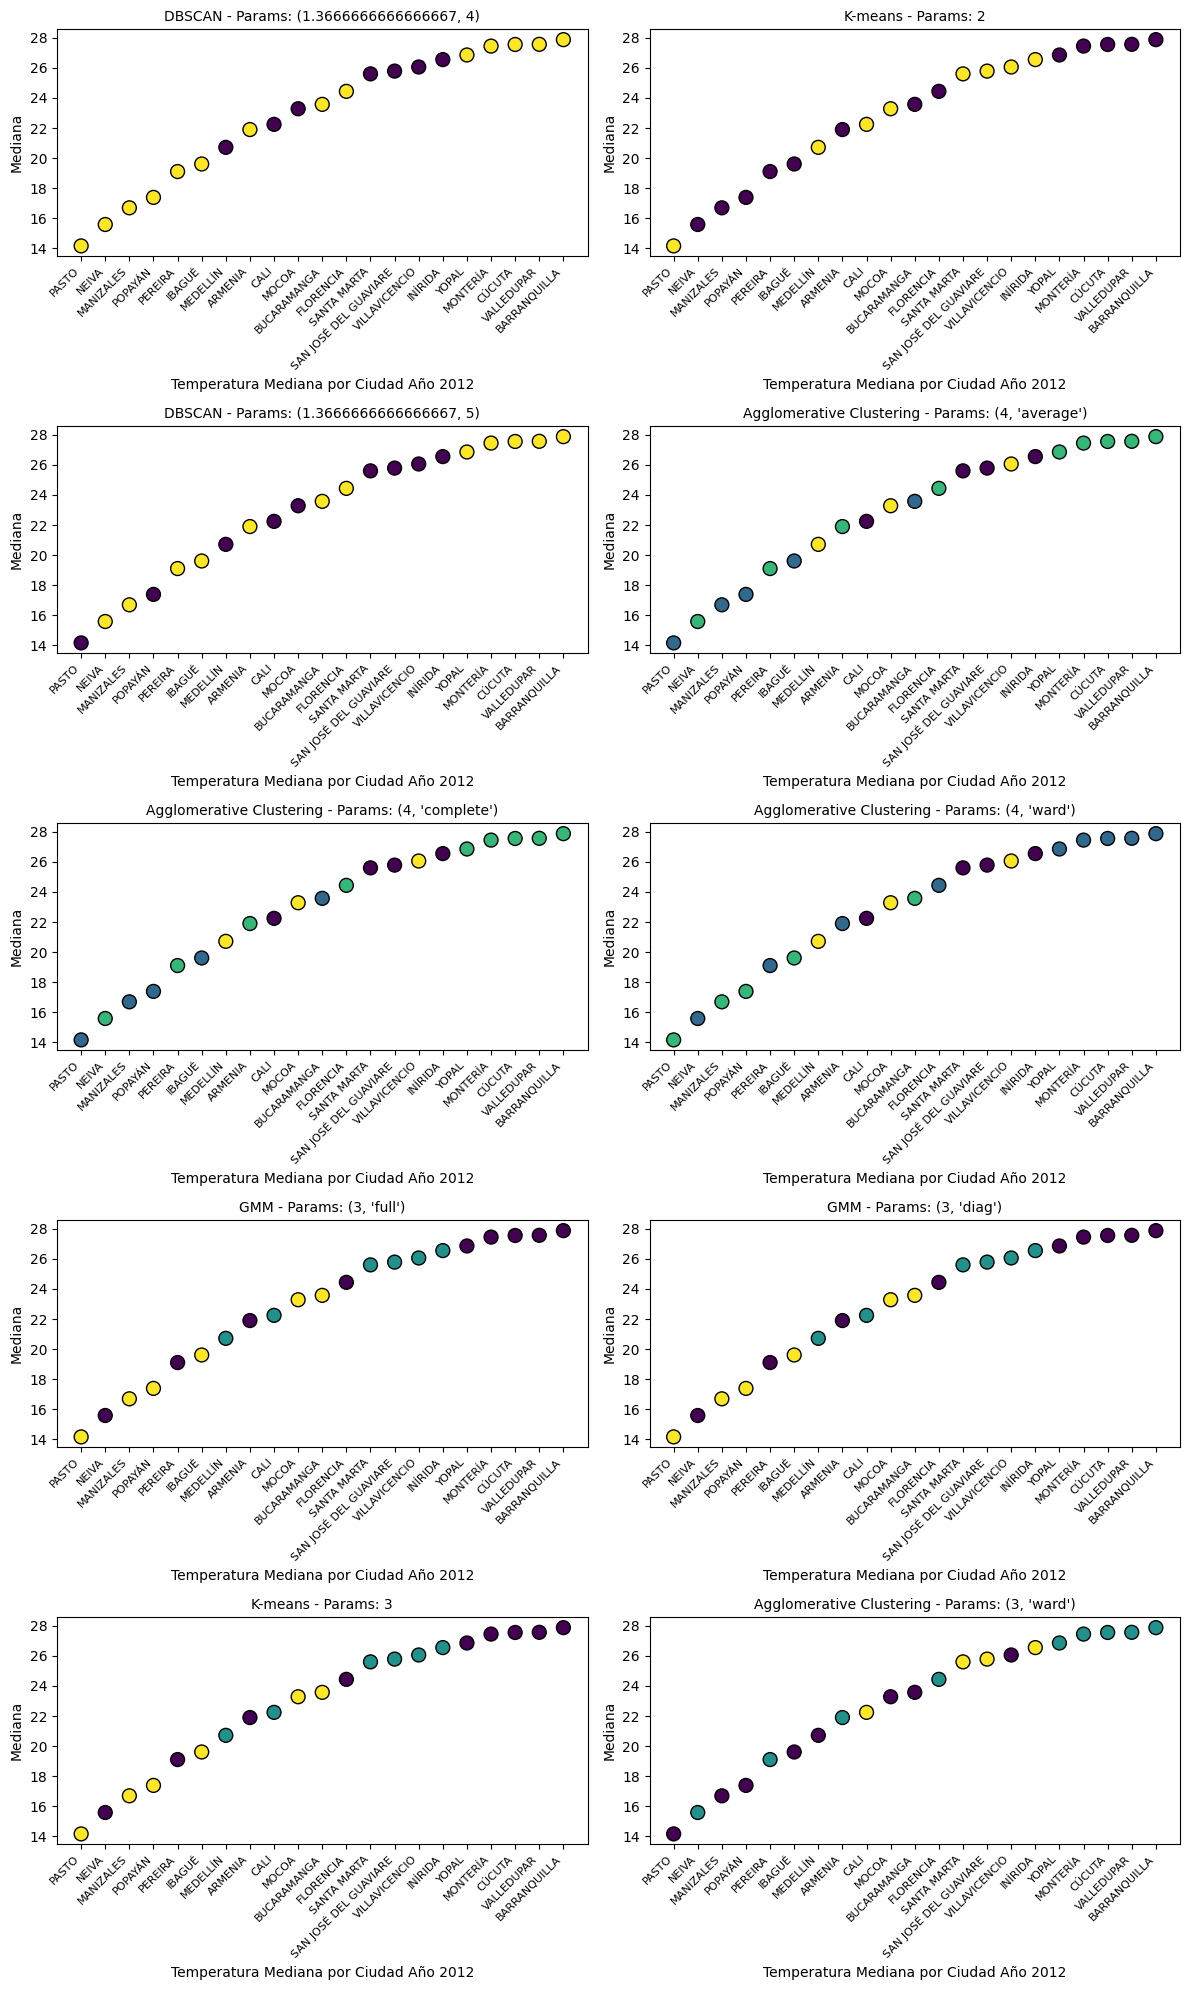

In [50]:
fig, axes = plt.subplots(5, 2, figsize=(12, 20))
axes = axes.flatten()

for i, (model_name, params, labels) in enumerate(top_models_labels):
    ax = axes[i]
    # Asumiendo que 'estadisticas_primer_ano' tiene las columnas 'Ciudad' y 'Promedio'
    # Si no es así, ajusta el DataFrame y las columnas en consecuencia
    scatter = ax.scatter(
        estadisticas_primer_ano['Ciudad'], estadisticas_primer_ano['Mediana'], c=labels, cmap='viridis', s=100, edgecolor='k'
    )
    ax.set_title(f'{model_name} - Params: {params}', fontsize=10)
    ax.set_xlabel('Temperatura Mediana por Ciudad Año 2012')
    ax.set_ylabel('Mediana')
    ax.set_xticklabels(estadisticas_primer_ano['Ciudad'], rotation=45, ha='right', fontsize=8)
    ax.grid(False)

plt.tight_layout()
plt.show()

##Torneo de Modelos para Ultimo Año (2022)

In [51]:
# Almacenar resultados
gridsearch_results = []

##Primer Modelo: K-MEANS

In [52]:
best_kmeans = None
best_kmeans_score = -1
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data)
    silhouette, dbi = evaluate_model(labels, data)
    gridsearch_results.append(("K-means", k, silhouette, dbi))
    if silhouette > best_kmeans_score:
        best_kmeans_score = silhouette
        best_kmeans = (kmeans, labels)

##Segundo Modelo: Gaussian Mixture

In [53]:
best_gmm = None
best_gmm_score = -1
for n_components, covariance_type in product(range(2, 6), ['full', 'diag']):
    gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
    labels = gmm.fit_predict(data)
    silhouette, dbi = evaluate_model(labels, data)
    gridsearch_results.append(("GMM", (n_components, covariance_type), silhouette, dbi))
    if silhouette > best_gmm_score:
        best_gmm_score = silhouette
        best_gmm = (gmm, labels)

##Tercer Modelo: Agglomerative Clustering

In [54]:
best_agglo = None
best_agglo_score = -1
for k, linkage in product(range(2, 6), ['ward', 'complete', 'average']):
    agglo = AgglomerativeClustering(n_clusters=k, linkage=linkage)
    labels = agglo.fit_predict(data)
    silhouette, dbi = evaluate_model(labels, data)
    gridsearch_results.append(("Agglomerative Clustering", (k, linkage), silhouette, dbi))
    if silhouette > best_agglo_score:
        best_agglo_score = silhouette
        best_agglo = (agglo, labels)

##Cuarto Modelo: Mean Shift

In [55]:
best_meanshift = None
best_meanshift_score = -1
bandwidth_values = np.linspace(0.1, 2.0, 10)
for bandwidth in bandwidth_values:
    meanshift = MeanShift(bandwidth=bandwidth)
    labels = meanshift.fit_predict(data)
    silhouette, dbi = evaluate_model(labels, data)
    gridsearch_results.append(("Mean Shift", bandwidth, silhouette, dbi))
    if silhouette > best_meanshift_score:
        best_meanshift_score = silhouette
        best_meanshift = (meanshift, labels)

##Quinto Modelo: DBSCAN

In [56]:
best_dbscan = None
best_dbscan_score = -1
eps_values = np.linspace(0.1, 2.0, 10)
min_samples_values = range(2, 6)
for eps, min_samples in product(eps_values, min_samples_values):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    silhouette, dbi = evaluate_model(labels, data)
    gridsearch_results.append(("DBSCAN", (eps, min_samples), silhouette, dbi))
    if silhouette > best_dbscan_score:
        best_dbscan_score = silhouette
        best_dbscan = (dbscan, labels)

Consolidar resultados en un dataframe

In [57]:
results_df_new = pd.DataFrame(gridsearch_results, columns=['Model', 'Parameters', 'Silhouette Score', 'Davies-Bouldin Index'])

In [58]:
top_10_last_year = results_df_new.sort_values(by='Silhouette Score', ascending=False)

In [59]:
top_10_last_year.head()

Model               Parameters  Silhouette Score  \
60                    DBSCAN  (1.3666666666666667, 4)          0.634268   
0                    K-means                        2          0.618051   
61                    DBSCAN  (1.3666666666666667, 5)          0.617587   
20  Agglomerative Clustering             (4, average)          0.603617   
19  Agglomerative Clustering            (4, complete)          0.603617   

    Davies-Bouldin Index  
60              0.457290  
0               0.480514  
61              0.484369  
20              0.429823  
19              0.429823

Filtrar los 10 mejores modelos segun coeficiente de silueta.

In [60]:
top_10_results = top_10_last_year.head(10)

Dataframe con etiquetas y clusters

In [61]:
top_models_labels = []
for idx, row in top_10_results.iterrows():
    model_name = row['Model']
    params = row['Parameters']

    if model_name == 'K-means':
        model = KMeans(n_clusters=params, random_state=42)
        labels = model.fit_predict(data)
    elif model_name == 'GMM':
        n_components, covariance_type = params
        model = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
        labels = model.fit_predict(data)
    elif model_name == 'K-medoids':
        initial_medoids = kmeans_plusplus_initializer(data, params).initialize(return_index=True)
        distance_matrix = calculate_distance_matrix(data)
        model = kmedoids(distance_matrix, initial_medoids, data_type='distance_matrix')
        model.process()
        labels = np.array(model.predict(data))
    elif model_name == 'Agglomerative Clustering':
        n_clusters, linkage = params
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        labels = model.fit_predict(data)
    elif model_name == 'Mean Shift':
        model = MeanShift(bandwidth=params)
        labels = model.fit_predict(data)
    elif model_name == 'DBSCAN':
        eps, min_samples = params
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(data)

    top_models_labels.append((model_name, params, labels))

In [62]:
estadisticas_ultimo_ano = estadisticas_ultimo_ano.sort_values('Mediana')

Graficar clusters

C:\Users\57319\AppData\Local\Temp\ipykernel_24076\4078384366.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(estadisticas_ultimo_ano['Ciudad'], rotation=45, ha='right', fontsize=8)
C:\Users\57319\AppData\Local\Temp\ipykernel_24076\4078384366.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(estadisticas_ultimo_ano['Ciudad'], rotation=45, ha='right', fontsize=8)
C:\Users\57319\AppData\Local\Temp\ipykernel_24076\4078384366.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(estadisticas_ultimo_ano['Ciudad'], rotation=45, ha='right', fontsize=8)
C:\Users\57319\AppData\Local\Temp\ipykernel_24076\4078384366.py:14: UserWarning: set_ticklabels() should only be used with a fixed nu

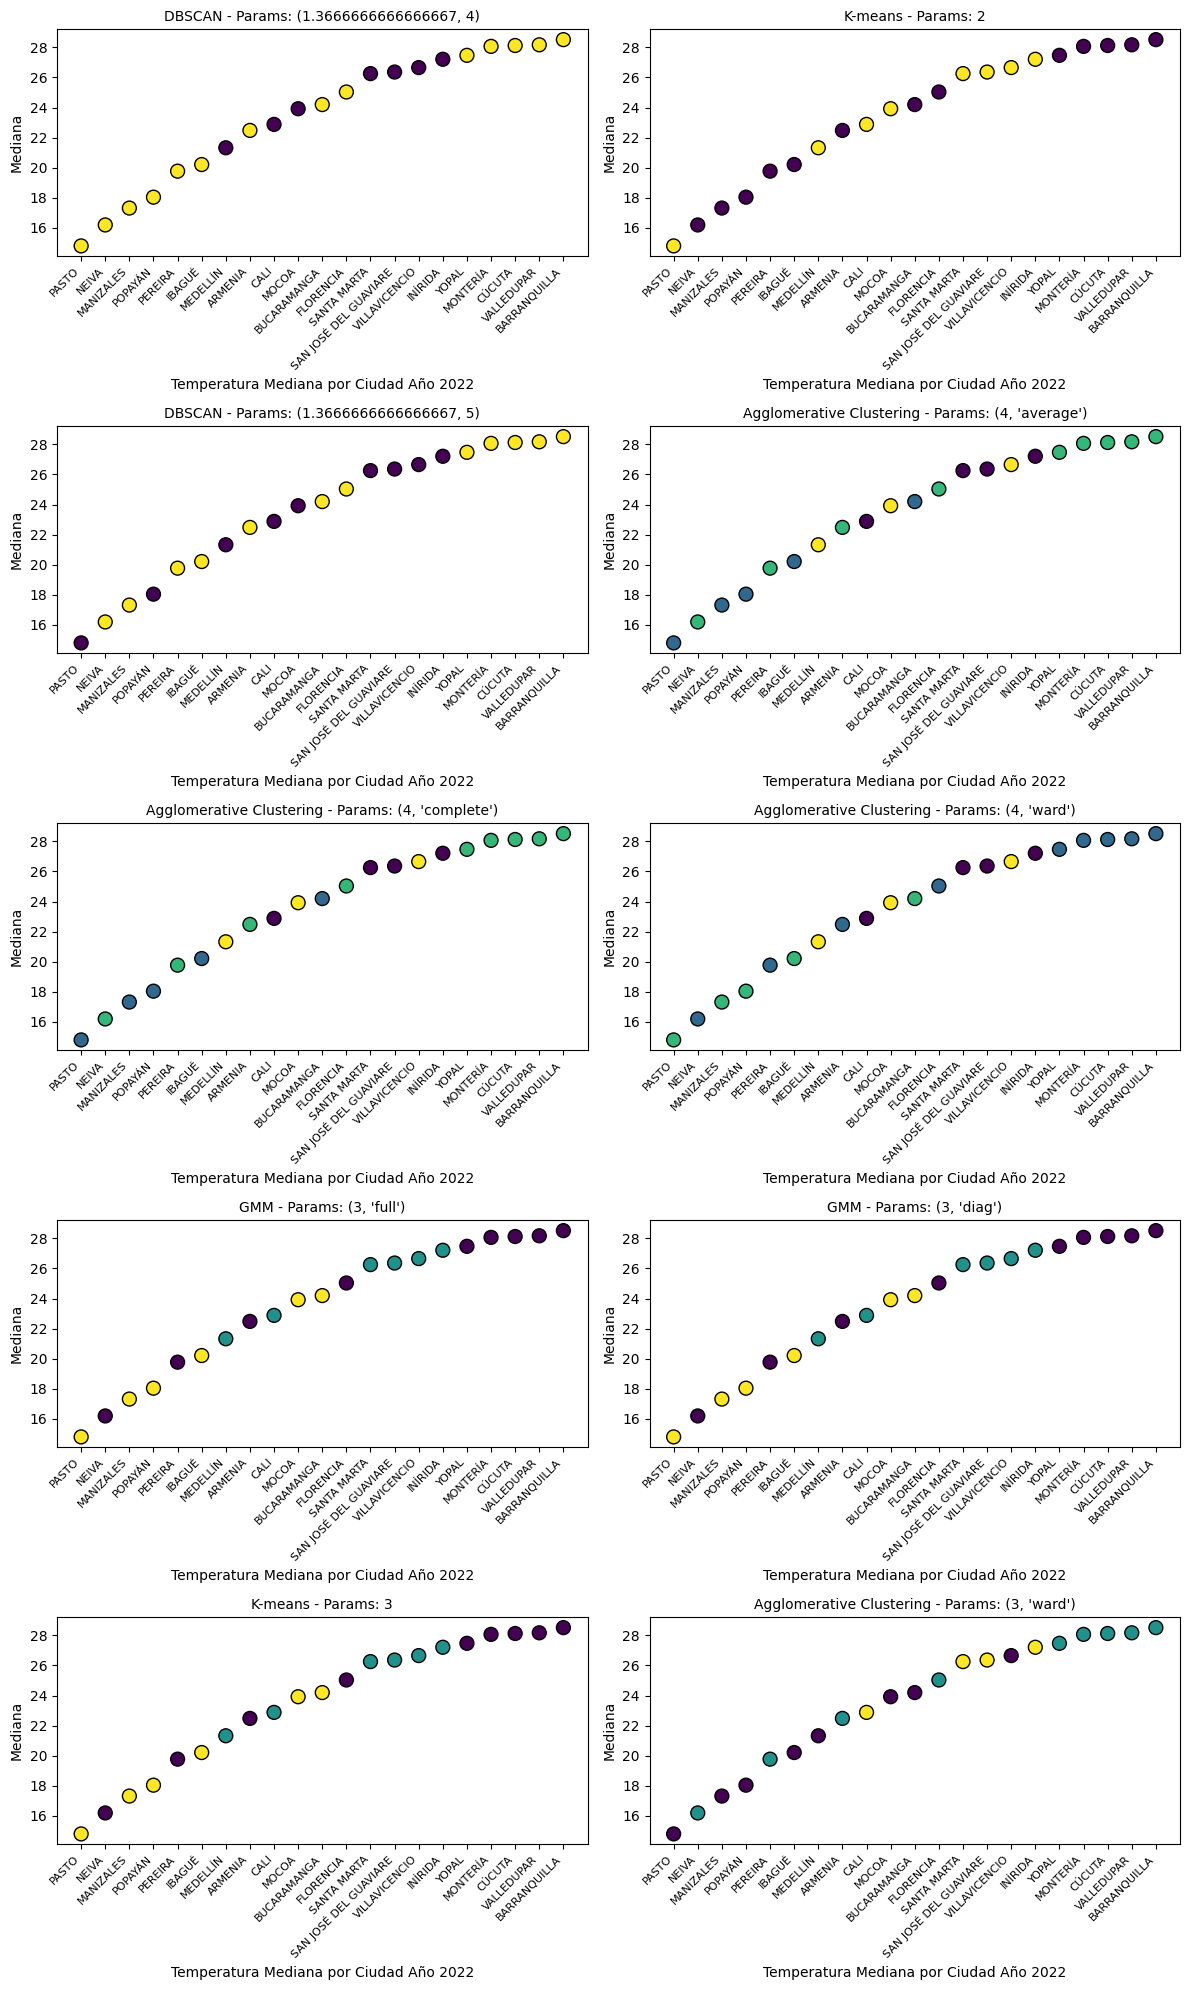

In [63]:
fig, axes = plt.subplots(5, 2, figsize=(12, 20))
axes = axes.flatten()

for i, (model_name, params, labels) in enumerate(top_models_labels):
    ax = axes[i]
    # Asumiendo que 'estadisticas_ultimo_ano' tiene las columnas 'Ciudad' y 'Promedio'
    # Si no es así, ajusta el DataFrame y las columnas en consecuencia
    scatter = ax.scatter(
        estadisticas_ultimo_ano['Ciudad'], estadisticas_ultimo_ano['Mediana'], c=labels, cmap='viridis', s=100, edgecolor='k'
    )
    ax.set_title(f'{model_name} - Params: {params}', fontsize=10)
    ax.set_xlabel('Temperatura Mediana por Ciudad Año 2022')
    ax.set_ylabel('Mediana')
    ax.set_xticklabels(estadisticas_ultimo_ano['Ciudad'], rotation=45, ha='right', fontsize=8)
    ax.grid(False)

plt.tight_layout()
plt.show()

##Utilizar el Modelo Ganador (K-MEANS)

Cluster para el primer año 2012

In [64]:
kmeans_primer = KMeans(n_clusters=3, random_state=42)

# Ajustar el modelo K-means
estadisticas_primer_ano['Cluster'] = kmeans_primer.fit_predict(estadisticas_primer_ano[['Mediana']])

# Mostrar los resultados del K-means
print("Resultado del K-means:")
print(estadisticas_primer_ano)




Resultado del K-means:
                   Ciudad     Maxima     Minima   Promedio    Mediana  Cluster
13                  PASTO  22.149383   6.805714  14.175143  14.168445        2
12                  NEIVA  22.613716   9.149391  15.592341  15.591167        2
8               MANIZALES  25.380636   8.649597  16.716576  16.699778        2
15                POPAYÁN  27.836274   7.674265  17.399224  17.391811        2
14                PEREIRA  30.558685   8.311361  19.132889  19.109898        0
6                  IBAGUÉ  30.809396   8.968899  19.621621  19.613053        0
9                MEDELLÍN  30.674461  11.424577  20.749719  20.718571        0
0                 ARMENIA  32.125086  12.235026  21.903624  21.901637        0
3                    CALI  35.373157   9.754957  22.282819  22.246497        0
10                  MOCOA  30.711310  16.509699  23.294632  23.284578        0
2             BUCARAMANGA  31.222009  16.558411  23.579163  23.576390        0
5               FLORENCIA  33

Cluster para el 2do año 2022

In [65]:
kmeans_ultimo = KMeans(n_clusters=3, random_state=42)

# Ajustar el modelo K-means
estadisticas_ultimo_ano['Cluster'] = kmeans_ultimo.fit_predict(estadisticas_ultimo_ano[['Mediana']])

# Mostrar los resultados del K-means
print("Resultado del K-means:")
print(estadisticas_ultimo_ano)



Resultado del K-means:
                   Ciudad     Maxima     Minima   Promedio    Mediana  Cluster
13                  PASTO  22.158668   6.808231  14.768964  14.790412        2
12                  NEIVA  22.605709   9.138909  16.180272  16.185023        2
8               MANIZALES  25.382038   8.650298  17.309671  17.309291        2
15                POPAYÁN  27.813830   7.683834  18.054685  18.033896        2
14                PEREIRA  30.601339   8.293404  19.755743  19.765087        0
6                  IBAGUÉ  30.814129   8.992728  20.173167  20.205517        0
9                MEDELLÍN  30.676091  11.434736  21.326169  21.321470        0
0                 ARMENIA  32.142891  12.253779  22.486460  22.477507        0
3                    CALI  35.414918   9.750751  22.888320  22.878473        0
10                  MOCOA  30.708970  16.489696  23.922090  23.920763        0
2             BUCARAMANGA  31.231665  16.558204  24.214711  24.196702        0
5               FLORENCIA  33

Asignacion de pisos termicos segun temperaturas

In [66]:
# Definir los rangos de temperatura y los valores asociados
conditions = [
    (estadisticas_primer_ano['Promedio'] >= 25),  # Condición para cálido
    (estadisticas_primer_ano['Promedio'] >= 17) & (estadisticas_primer_ano['Promedio'] < 25),  # Condición para medio
    (estadisticas_primer_ano['Promedio'] < 17)  # Condición para frío
]
values = ['Calido', 'Medio', 'Frio']  # 0 = cálido, 2 = medio, 1 = frío

# Crear la nueva columna para el primer año
estadisticas_primer_ano['Clima'] = np.select(conditions, values)

# Crear la nueva columna para el último año
estadisticas_ultimo_ano['Clima'] = np.select(conditions, values)

# Mostrar el DataFrame modificado
print(estadisticas_primer_ano)
print(estadisticas_ultimo_ano)

                   Ciudad     Maxima     Minima   Promedio    Mediana  \
13                  PASTO  22.149383   6.805714  14.175143  14.168445   
12                  NEIVA  22.613716   9.149391  15.592341  15.591167   
8               MANIZALES  25.380636   8.649597  16.716576  16.699778   
15                POPAYÁN  27.836274   7.674265  17.399224  17.391811   
14                PEREIRA  30.558685   8.311361  19.132889  19.109898   
6                  IBAGUÉ  30.809396   8.968899  19.621621  19.613053   
9                MEDELLÍN  30.674461  11.424577  20.749719  20.718571   
0                 ARMENIA  32.125086  12.235026  21.903624  21.901637   
3                    CALI  35.373157   9.754957  22.282819  22.246497   
10                  MOCOA  30.711310  16.509699  23.294632  23.284578   
2             BUCARAMANGA  31.222009  16.558411  23.579163  23.576390   
5               FLORENCIA  33.400496  16.077915  24.441234  24.440111   
17            SANTA MARTA  41.498476  10.345384  25

Ordenar los datos para graficar clusters

In [67]:
# Ordenar los datos por la columna 'Promedio' para ambos años
estadisticas_primer_ano = estadisticas_primer_ano.sort_values('Mediana')
estadisticas_ultimo_ano = estadisticas_ultimo_ano.sort_values('Mediana')

Grafica para primer año 2012

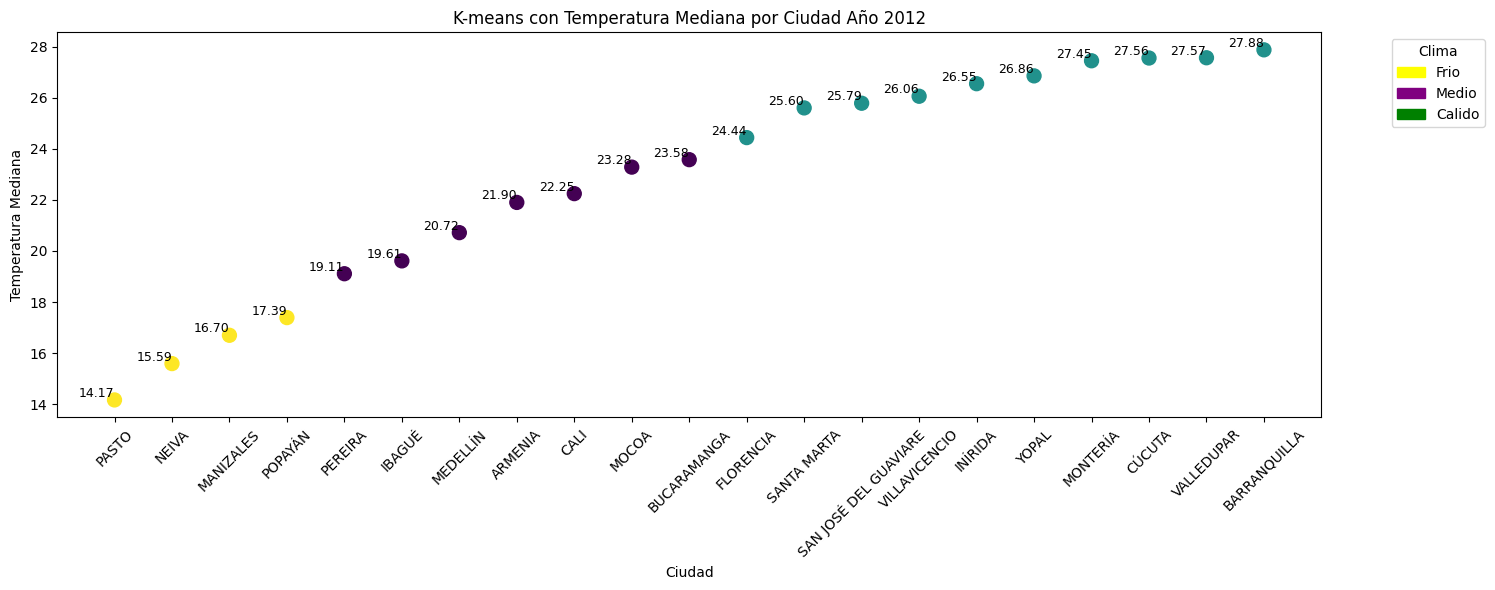

<Figure size 640x480 with 0 Axes>

In [68]:
# Ordenar los datos por la columna 'Promedio' para ambos años
estadisticas_primer_ano = estadisticas_primer_ano.sort_values('Mediana')
estadisticas_ultimo_ano = estadisticas_ultimo_ano.sort_values('Mediana')

# Gráfico 1: K-means para el primer año
plt.figure(figsize=(15, 6))  # Crear una nueva figura
plt.scatter(estadisticas_primer_ano['Ciudad'], estadisticas_primer_ano['Mediana'],
            c=estadisticas_primer_ano['Cluster'], cmap='viridis', s=100)
plt.xlabel('Ciudad')
plt.ylabel('Temperatura Mediana')
plt.title('K-means con Temperatura Mediana por Ciudad Año 2012')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x

for i, row in estadisticas_primer_ano.iterrows():
    plt.text(row['Ciudad'], row['Mediana'],
             f"{row['Mediana']:.2f}",  # Etiqueta con valor numérico y clima
             fontsize=9, ha='right', va='bottom')

# Crear una leyenda personalizada para la variable "Clima"
unique_clima = estadisticas_primer_ano['Clima'].unique()
color_map = {'Calido': 'green', 'Medio': 'purple', 'Frio': 'yellow'}  # Colores representativos
clima_patches = [mpatches.Patch(color=color_map[clima], label=clima) for clima in unique_clima]
plt.legend(handles=clima_patches, title='Clima', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

plt.tight_layout()  # Ajustar el diseño
plt.show()  # Mostrar el gráfico

Graficar para el 2do año 2022

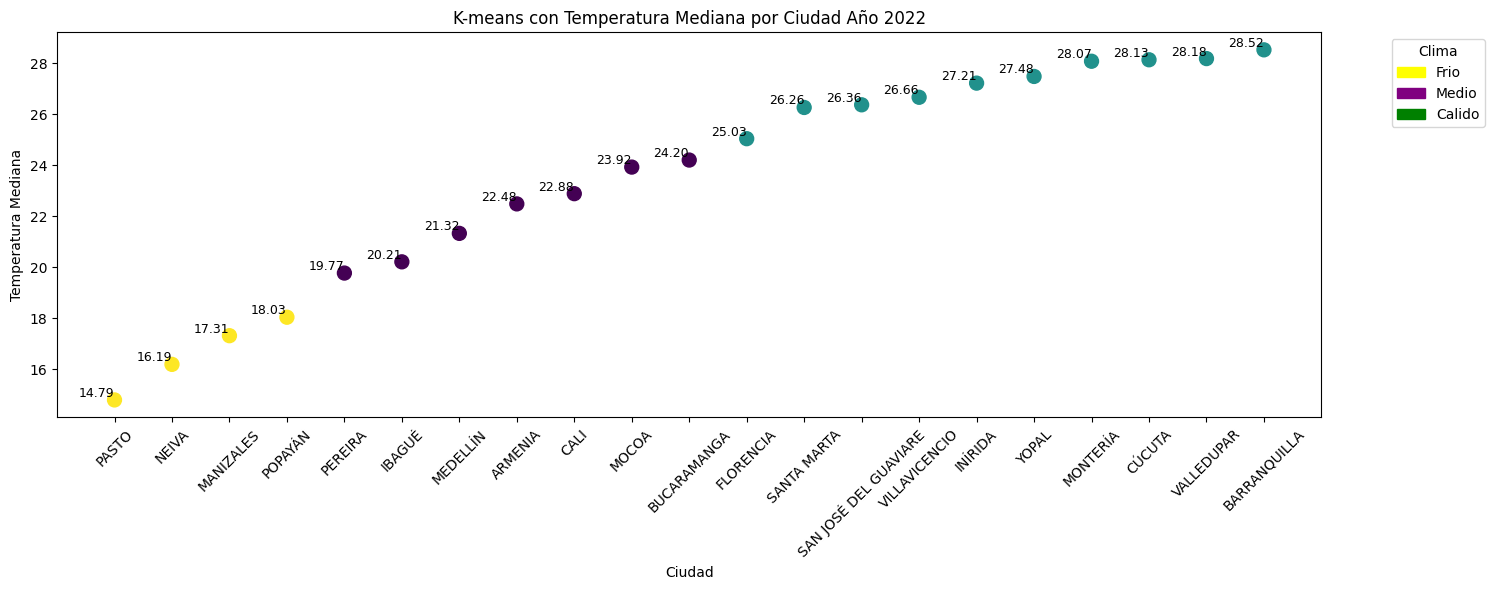

In [69]:
plt.figure(figsize=(15, 6))  # Crear otra figura
plt.scatter(estadisticas_ultimo_ano['Ciudad'], estadisticas_ultimo_ano['Mediana'],
            c=estadisticas_ultimo_ano['Cluster'], cmap='viridis', s=100, label=estadisticas_ultimo_ano['Clima'])
plt.xlabel('Ciudad')
plt.ylabel('Temperatura Mediana')
plt.title('K-means con Temperatura Mediana por Ciudad Año 2022')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x

# Agregar etiquetas con los valores numéricos
for i, row in estadisticas_ultimo_ano.iterrows():
    plt.text(row['Ciudad'], row['Mediana'], f"{row['Mediana']:.2f}", fontsize=9, ha='right', va='bottom')

# Crear una leyenda personalizada para la variable "Clima"
unique_clima = estadisticas_ultimo_ano['Clima'].unique()
color_map = {'Calido': 'green', 'Medio': 'purple', 'Frio': 'yellow'}  # Colores representativos
clima_patches = [mpatches.Patch(color=color_map[clima], label=clima) for clima in unique_clima]
plt.legend(handles=clima_patches, title='Clima', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Ajustar el diseño
plt.show()  # Mostrar el gráfico

Grafica que unifica temperaturas medianas de 2012 y 2022

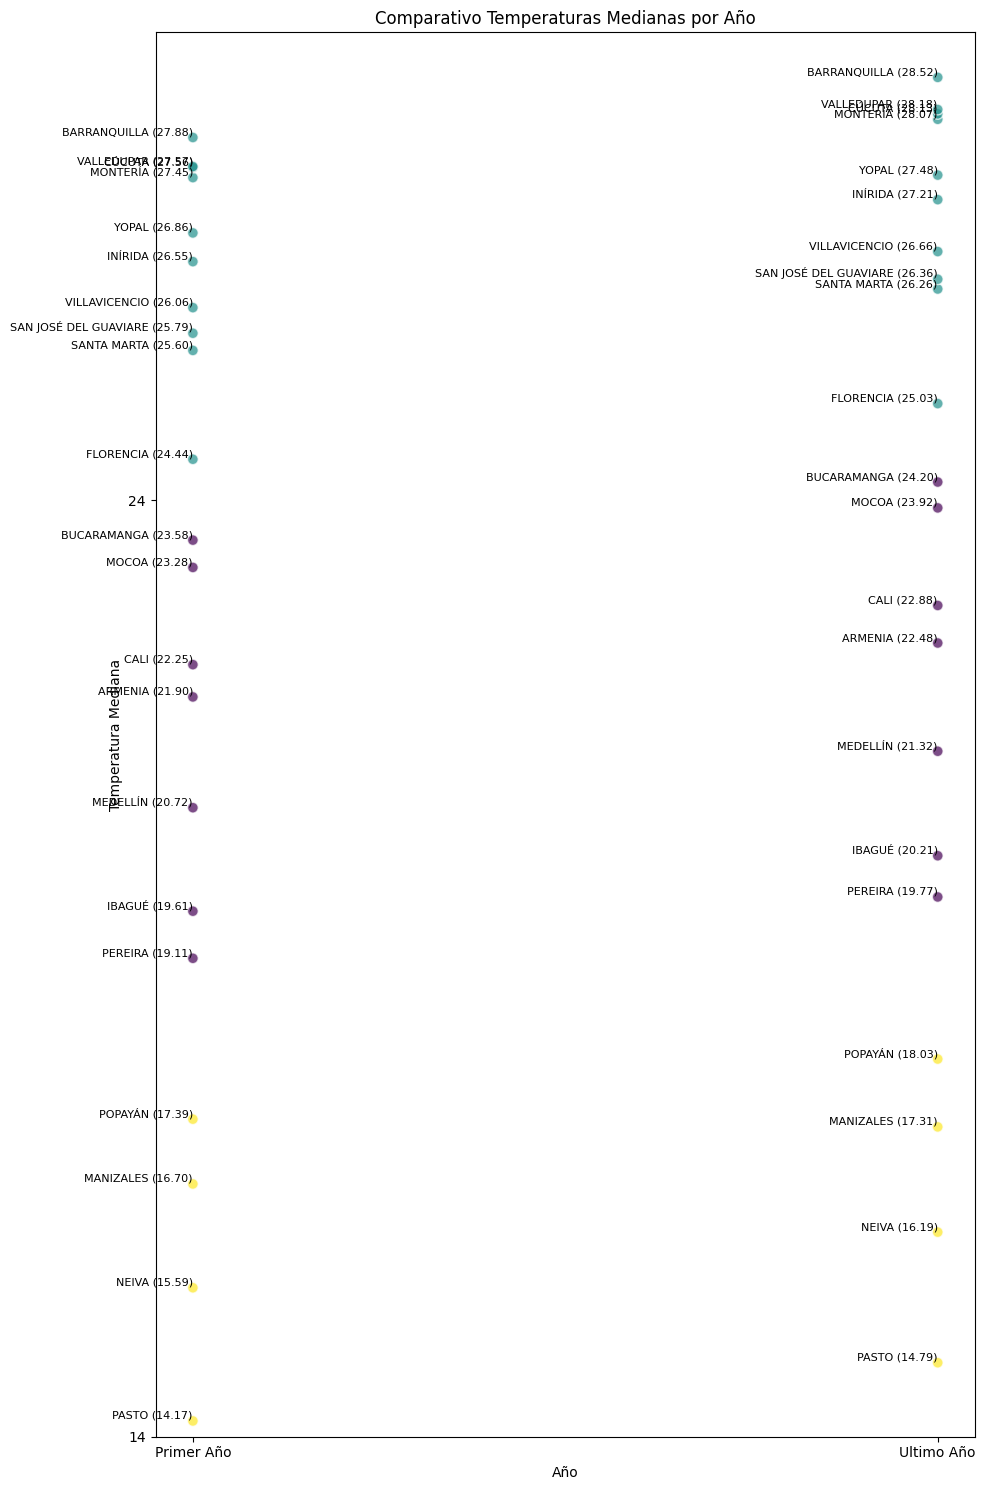

In [70]:
# Crear una columna adicional para identificar el año
estadisticas_primer_ano['Año'] = 'Primer Año'
estadisticas_ultimo_ano['Año'] = 'Ultimo Año'

# Combinar los DataFrames
estadisticas_combinadas = pd.concat([estadisticas_primer_ano, estadisticas_ultimo_ano])

# Gráfico de dispersión
plt.figure(figsize=(10, 15))  # Reducir el tamaño del gráfico

scatter = plt.scatter(
    estadisticas_combinadas['Año'],  # Eje x: Año
    estadisticas_combinadas['Mediana'],  # Eje y: Temperatura mediana
    c=estadisticas_combinadas['Cluster'],  # Color basado en el clúster
    cmap='viridis', s=60, alpha=0.7, edgecolors='w'  # Reducir tamaño de puntos (s=50)
)

# Agregar etiquetas a los puntos
for i, row in estadisticas_combinadas.iterrows():
    plt.text(
        row['Año'], row['Mediana'],
        f"{row['Ciudad']} ({row['Mediana']:.2f})",  # Etiqueta con ciudad y temperatura
        fontsize=8, ha='right', va='bottom'
    )

# Ajustar el rango del eje y para reducir la escala
plt.ylim(14, 29)  # Cambiar los valores mínimos y máximos según las temperaturas
plt.yticks(range(14, 29, 10))  # Cambiar los intervalos a cada 5 unidades (10, 15, 20, ...)

# Etiquetas y título
plt.xlabel('Año')
plt.ylabel('Temperatura Mediana')
plt.title('Comparativo Temperaturas Medianas por Año')

# Ajustar el diseño y mostrar
plt.tight_layout()
plt.show()

Obtenemos distancias para analizar cuanto ha cambiado la temperatura

In [71]:
estadisticas_combinadas.head()

Ciudad     Maxima    Minima   Promedio    Mediana  Cluster  Clima  \
13      PASTO  22.149383  6.805714  14.175143  14.168445        2   Frio   
12      NEIVA  22.613716  9.149391  15.592341  15.591167        2   Frio   
8   MANIZALES  25.380636  8.649597  16.716576  16.699778        2   Frio   
15    POPAYÁN  27.836274  7.674265  17.399224  17.391811        2  Medio   
14    PEREIRA  30.558685  8.311361  19.132889  19.109898        0  Medio   

           Año  
13  Primer Año  
12  Primer Año  
8   Primer Año  
15  Primer Año  
14  Primer Año

Distancia euclidiana.

In [72]:
# Filtrar las temperaturas por año
primer_ano = estadisticas_combinadas[estadisticas_combinadas['Año'] == 'Primer Año'].set_index('Ciudad')['Mediana']
ultimo_ano = estadisticas_combinadas[estadisticas_combinadas['Año'] == 'Ultimo Año'].set_index('Ciudad')['Mediana']

# Asegurar que las ciudades estén alineadas
primer_ano = primer_ano.sort_index()
ultimo_ano = ultimo_ano.sort_index()

# Calcular las distancias individuales entre las temperaturas de los dos años
distancias_por_ciudad = np.abs(primer_ano - ultimo_ano)

# Calcular la distancia euclidiana total entre los años
distancia_euclidiana_total = np.linalg.norm(primer_ano.values - ultimo_ano.values)

# Crear un DataFrame con las distancias individuales
distancias_por_ciudad_df = pd.DataFrame({
    'Ciudad': primer_ano.index,
    'Distancia Euclidiana': distancias_por_ciudad
}).reset_index(drop=True)

# Mostrar los resultados
print("Distancia Euclidiana Total entre 'Primer Año' y 'Último Año':", distancia_euclidiana_total)
print("\nDistancia Euclidiana por Ciudad:")
print(distancias_por_ciudad_df)

Distancia Euclidiana Total entre 'Primer Año' y 'Último Año': 2.8251949658404087

Distancia Euclidiana por Ciudad:
                   Ciudad  Distancia Euclidiana
0                 ARMENIA              0.575870
1            BARRANQUILLA              0.641896
2             BUCARAMANGA              0.620312
3                    CALI              0.631976
4                  CÚCUTA              0.573167
5               FLORENCIA              0.594507
6                  IBAGUÉ              0.592464
7                 INÍRIDA              0.662094
8               MANIZALES              0.609512
9                MEDELLÍN              0.602899
10                  MOCOA              0.636185
11               MONTERÍA              0.622668
12                  NEIVA              0.593856
13                  PASTO              0.621967
14                PEREIRA              0.655190
15                POPAYÁN              0.642085
16  SAN JOSÉ DEL GUAVIARE              0.576862
17            SANTA M

##Mapa de calor para visualizar variaciones

In [73]:
matriz_distancias_ciudad_vs_anio = pd.DataFrame({
    'Ciudad': primer_ano.index,
    'Distancia Euclidiana': distancias_por_ciudad.values
}).set_index('Ciudad')

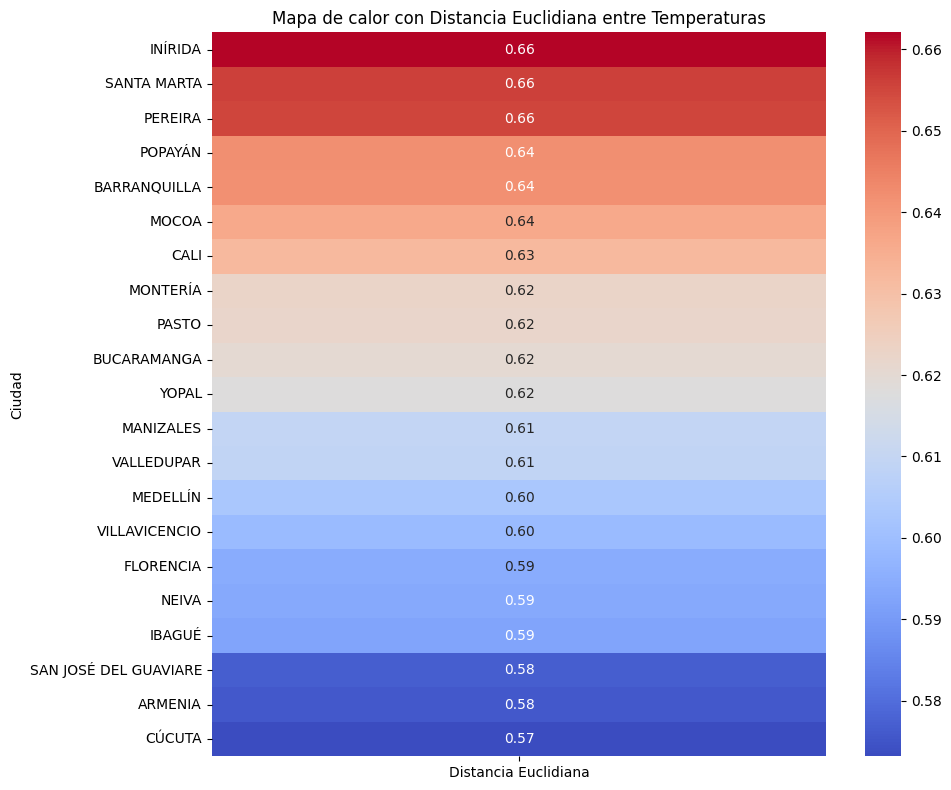

In [74]:
matriz_ordenada = matriz_distancias_ciudad_vs_anio.sort_values('Distancia Euclidiana', ascending=False)

# Crear un mapa de calor para la matriz ordenada
plt.figure(figsize=(10, 8))
sns.heatmap(
    matriz_ordenada[['Distancia Euclidiana']],
    annot=True,  # Mostrar los valores en las celdas
    fmt=".2f",   # Formato de los números
    cmap="coolwarm",  # Mapa de colores
)

# Configurar etiquetas y título
plt.title("Mapa de calor con Distancia Euclidiana entre Temperaturas")
plt.tight_layout()

# Mostrar el gráfico
plt.show()

##Generar un nuevo K-MEANS con las distancias euclidianas encontradas.

In [75]:
matriz_agrupaciones_informacion = pd.DataFrame({
    'Ciudad': primer_ano.index,
    'Distancia Euclidiana': distancias_por_ciudad.values
})

In [76]:
matriz_agrupaciones_informacion

Ciudad  Distancia Euclidiana
0                 ARMENIA              0.575870
1            BARRANQUILLA              0.641896
2             BUCARAMANGA              0.620312
3                    CALI              0.631976
4                  CÚCUTA              0.573167
5               FLORENCIA              0.594507
6                  IBAGUÉ              0.592464
7                 INÍRIDA              0.662094
8               MANIZALES              0.609512
9                MEDELLÍN              0.602899
10                  MOCOA              0.636185
11               MONTERÍA              0.622668
12                  NEIVA              0.593856
13                  PASTO              0.621967
14                PEREIRA              0.655190
15                POPAYÁN              0.642085
16  SAN JOSÉ DEL GUAVIARE              0.576862
17            SANTA MARTA              0.655859
18             VALLEDUPAR              0.609135
19          VILLAVICENCIO              0.598720
20                  YOPAL              0.617756

In [77]:
kmeans_agrupado = KMeans(n_clusters=2, random_state=42)

In [78]:
# Ajustar el modelo K-means
matriz_agrupaciones_informacion['Cluster'] = kmeans_agrupado.fit_predict(matriz_agrupaciones_informacion[['Distancia Euclidiana']])

In [79]:
print("Resultado del K-means:")
print(matriz_agrupaciones_informacion)

Resultado del K-means:
                   Ciudad  Distancia Euclidiana  Cluster
0                 ARMENIA              0.575870        1
1            BARRANQUILLA              0.641896        0
2             BUCARAMANGA              0.620312        1
3                    CALI              0.631976        0
4                  CÚCUTA              0.573167        1
5               FLORENCIA              0.594507        1
6                  IBAGUÉ              0.592464        1
7                 INÍRIDA              0.662094        0
8               MANIZALES              0.609512        1
9                MEDELLÍN              0.602899        1
10                  MOCOA              0.636185        0
11               MONTERÍA              0.622668        1
12                  NEIVA              0.593856        1
13                  PASTO              0.621967        1
14                PEREIRA              0.655190        0
15                POPAYÁN              0.642085        0
16  SAN 

Anexarle una condicion para separar los clusters

In [80]:
# Definir los rangos de temperatura y los valores asociados
conditions = [
    (matriz_agrupaciones_informacion['Distancia Euclidiana'] >= 0.62),  # Condición para cálido
    (matriz_agrupaciones_informacion['Distancia Euclidiana'] < 0.62)  # Condición para frío
]
values = ['Alta', 'Baja']  # 0 = cálido, 2 = medio, 1 = frío

In [81]:
matriz_agrupaciones_informacion['Clima'] = np.select(conditions, values)

In [82]:
matriz_agrupaciones_informacion = matriz_agrupaciones_informacion.sort_values('Distancia Euclidiana')

Cluster variaciones

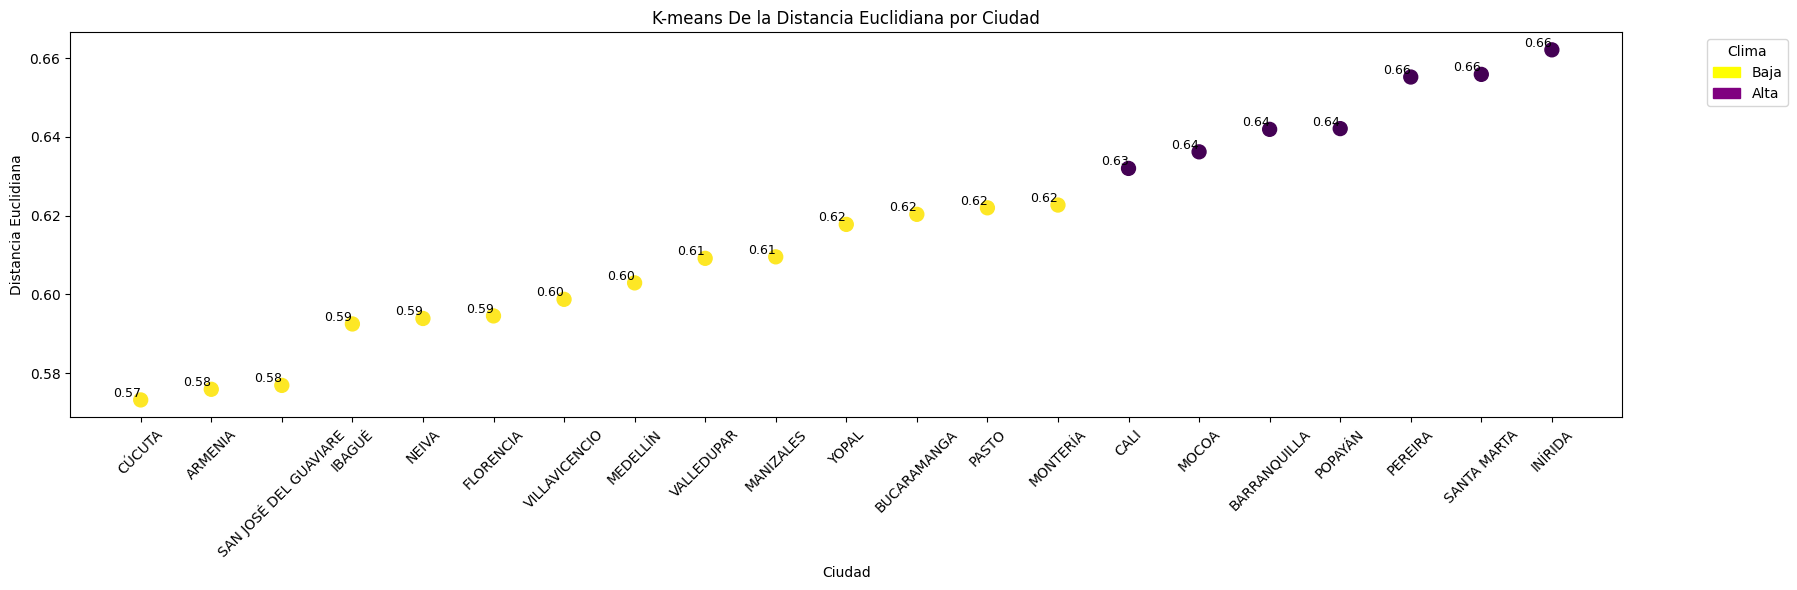

<Figure size 640x480 with 0 Axes>

In [83]:
plt.figure(figsize=(18, 6))  # Crear una nueva figura
plt.scatter(matriz_agrupaciones_informacion['Ciudad'], matriz_agrupaciones_informacion['Distancia Euclidiana'],
            c=matriz_agrupaciones_informacion['Cluster'], cmap='viridis', s=100)
plt.xlabel('Ciudad')
plt.ylabel('Distancia Euclidiana')
plt.title('K-means De la Distancia Euclidiana por Ciudad')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x

for i, row in matriz_agrupaciones_informacion.iterrows():
    plt.text(row['Ciudad'], row['Distancia Euclidiana'],
             f"{row['Distancia Euclidiana']:.2f}",  # Etiqueta con valor numérico y clima
             fontsize=9, ha='right', va='bottom')

unique_clima = matriz_agrupaciones_informacion['Clima'].unique()
color_map = {'Alta': 'purple', 'Baja': 'yellow'}  # Colores representativos
clima_patches = [mpatches.Patch(color=color_map[clima], label=clima) for clima in unique_clima]
plt.legend(handles=clima_patches, title='Clima', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()